In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import pandas as pd
import numpy as np  
import seaborn as sns 
import statsmodels.api as sm
import matplotlib.pyplot as plt
from pylab import rcParams
import itertools
import os
from sklearn.cluster import KMeans
import warnings 
warnings.filterwarnings("ignore")
import xgboost as xgb
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.svm import SVC
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold, cross_val_score, train_test_split
import keras
from keras.layers import Dense
from keras.models import Sequential
from keras.optimizers import Adam 
from keras.callbacks import EarlyStopping
from keras.utils import np_utils
from keras.layers import LSTM
from sklearn.model_selection import KFold, cross_val_score, train_test_split

In [0]:
full_df=pd.read_csv('/content/drive/My Drive/DataScience/FinalProject/Data/costello.csv')

In [0]:
full_df.columns = [c.replace(' ', '_') for c in full_df.columns]
full_df.columns = [c.replace('-', '_') for c in full_df.columns]

In [0]:
full_df.drop(full_df.loc[full_df['Store_Name'].isna()].index, inplace=True)

In [0]:
def SplitFrame(storeName):
  chunk=full_df[full_df['Store_Name']==storeName]
  chunk.to_csv('/content/drive/My Drive/DataScience/FinalProject/Data/'+storeName+'.csv')

In [0]:
#divide into chunks
lst_OnDivide=full_df['Store_Name'].unique()
for item in lst_OnDivide:
  SplitFrame(item)

In [0]:
storeName = '11116 BELLMORE'

In [0]:
#Reading Chunks
store_df=pd.read_csv('/content/drive/My Drive/DataScience/FinalProject/Data/'+storeName+'.csv', index_col=[0])

In [0]:
store_df_2 = pd.read_csv('/content/drive/My Drive/DataScience/FinalProject/11116 BELLMORE_2.csv', index_col=[0])

In [0]:
store_df = store_df_2.append(store_df)

In [0]:
store_df_2.shape

(1273548, 39)

In [0]:
store_df.shape

(2472076, 39)

In [0]:
#changing data types 
def convertToNum(colname):
  store_df[colname]=store_df[colname].fillna(-999)
  store_df[colname]=store_df[colname].astype(str)
  store_df[colname]=store_df[colname].str.replace(',', '')  
  store_df[colname]=store_df[colname].str.replace('%','')
  store_df[colname]=store_df[colname].str.replace(' ','')
  store_df[colname]=store_df[colname].str.replace('$','')
  store_df[colname]=store_df[colname].str.replace('(','')
  store_df[colname]=store_df[colname].str.replace(')','')
  store_df[colname] = pd.to_numeric(store_df[colname])
def convertToString(colname):
  store_df[colname]=store_df[colname].astype(str)
#Drop rows based on a condition on a column
def dropRows(data_frame,column,conditon):
  data_frame.drop(data_frame.loc[data_frame[column]==conditon].index, inplace=True)
def convertToDateTime(col):
  store_df[col] = pd.to_datetime(store_df[col]) 

In [0]:
# store_df['Customer_Number']=store_df['Customer_Number'].str.replace('*','')
# #  removing non numeric customers 87 in total ,do this before in store_df 
# store_df=store_df[store_df.Customer_Number.apply(lambda x: x.isnumeric())]
# store_df['Customer_Number'] = pd.to_numeric(store_df['Customer_Number'])

In [0]:
#24 rows with feature values as headers ,so removed using DATE as identifier
store_df.drop(store_df.loc[store_df['Date']=='Date'].index, inplace=True)

In [0]:
#removing duplicated data
store_df.drop_duplicates(keep=False,inplace=True) 

In [0]:
#Drop rows where column is NaN in Customer Number
store_df=store_df.dropna(subset=['Customer_Number'])

In [0]:
lstToCOnvert=['Net_Sales_Units','Net_Sales','Cost','Gross_Margin','Gross_Margin_%',
              'Actual_Price','Retail_Price','Item_was_Scanned','Dynamic_Promo_ID','$_Off_Retail','Actual_Retail']
for col in lstToCOnvert:
  convertToNum(col)

In [0]:
convertToDateTime('Date')

In [0]:
########Cleaning
store_df['Class_Code'].fillna('B1',inplace=True)
store_df['Fineline_Code'].fillna('B1',inplace=True)
store_df['MIP_Promo_ID'].fillna('No Discount',inplace=True)
store_df['Promo/Discount'].fillna('No Discount',inplace=True)
store_df['Zip_Code'].fillna('Not Registered ',inplace=True)
store_df['Zip_Plus_4'].fillna('Not Registered ',inplace=True)
store_df['Loyalty_ID'].fillna('Not Registered ',inplace=True)
store_df['Pricing_Source'].fillna('Unknown ',inplace=True)
store_df['Scanned_UPC'].fillna('Unknown ',inplace=True)
store_df['Return_Code'].fillna('Unknown ',inplace=True)
store_df['Item_was_Scanned'].fillna('Unknown ',inplace=True)
store_df.drop(columns='Gross_Margin_%',axis=1,inplace=True)

In [0]:
#Data frame for time series analysis
timeseries_GrossMargin=store_df.filter(['Date','Gross_Margin'])
timeseries_Sales = store_df.filter(['Date','Net_Sales'])

In [0]:
timeseries_GrossMargin = timeseries_GrossMargin.sort_values('Date')
timeseries_GrossMargin.groupby('Date')
timeseries_GrossMargin=timeseries_GrossMargin.set_index('Date')
timeseries_Sales = timeseries_Sales.sort_values('Date')
timeseries_Sales.groupby('Date')
timeseries_Sales=timeseries_Sales.set_index('Date')

In [0]:
def Forecast(period,validate_start,validate_end,predict_start,predict_end):
  if not os.path.isdir('/content/drive/My Drive/DataScience/FinalProject/'+storeName+'___'+period):
    os.makedirs('/content/drive/My Drive/DataScience/FinalProject/'+storeName+'___'+period)
  y_GrossMargin  = timeseries_GrossMargin['Gross_Margin'].resample(period).sum()
  y_Sales  = timeseries_Sales['Net_Sales'].resample(period).sum()
  #Plot Grossmargin compared with Sales
  y_GrossMargin.plot(figsize=(20, 8))
  y_Sales.plot(figsize=(20, 8))
  plt.xlabel("Date")
  plt.ylabel("Total Value")
  plt.title("Gross Margin compared with Sales")
  plt.legend()
  plt.savefig('/content/drive/My Drive/DataScience/FinalProject/'+storeName+'___'+period+'/Gross Margin compared with Sales.png', bbox_inches = "tight")
  plt.show()
  #Seasonal Decompose
  rcParams['figure.figsize'] = 15, 8
  decomposition = sm.tsa.seasonal_decompose(y_GrossMargin, model='additive')  
  fig = decomposition.plot()
  plt.savefig('/content/drive/My Drive/DataScience/FinalProject/'+storeName+'___'+period+'/decomposition.png', bbox_inches = "tight")
  plt.show()
  #Sarimax  model fitting
  p = d = q = range(0, 2)
  pdq = list(itertools.product(p, d, q))
  seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
  #split data into training data
  y_GrossMargin_train=y_GrossMargin['2015-01':'2018-06']
  ##############################
  for param in pdq:
      for param_seasonal in seasonal_pdq:
          try:
              mod = sm.tsa.statespace.SARIMAX(y_GrossMargin_train,
                                              order=param,
                                              seasonal_order=param_seasonal,
                                              enforce_stationarity=False,
                                              enforce_invertibility=False)
              results = mod.fit()
              print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
          except:
              continue
  # Optimal values of p,d and q ->ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:26.099158099099753
  #ARIMA(0, 1, 1)x(0, 1, 0, 12)12 - AIC:231.22919432787555
  mod = sm.tsa.statespace.SARIMAX(y_GrossMargin_train,
                                  order=(0, 1, 1),
                                  seasonal_order=(0, 1, 0, 12),
                                  enforce_stationarity=False,
                                  enforce_invertibility=False)
  results = mod.fit()
  print(results.summary())
  #Validate model 
  #Used  data from 2018 onwards to validate the model by comparing the observed and the predicted
  pred = results.get_prediction(start=pd.to_datetime(validate_start),end= pd.to_datetime(validate_end), dynamic=False)
  pred_ci = pred.conf_int()
  ax = y_GrossMargin['2015':].plot(label='observed')
  pred.predicted_mean.plot(ax=ax, label='Validate', alpha=.7, figsize=(14, 7),linewidth=3)
  ax.fill_between(pred_ci.index,
                  pred_ci.iloc[:, 0],
                  pred_ci.iloc[:, 1], color='k', alpha=.1)
  ax.set_xlabel('Date')
  ax.set_ylabel('Gross Margin')
  plt.legend()
  plt.savefig('/content/drive/My Drive/DataScience/FinalProject/'+storeName+'___'+period+'/validate.png', bbox_inches = "tight")
  plt.show()
  #Validation error handling
  y_forecasted = pred.predicted_mean
  y_truth = y_GrossMargin['2018-01-01':]
  mse = ((y_forecasted - y_truth) ** 2).mean()
  print('The Mean Squared Error of our validation is {}'.format(round(mse, 2)))
  print('The Root Mean Squared Error of our validation is {}'.format(round(np.sqrt(mse), 2)))

  #forecasting or predicting for future and connecting it to previous ggraph
  pred = results.get_prediction(start=pd.to_datetime(predict_start),end=predict_end, dynamic=False)
  pred_ci = pred.conf_int()
  ax = y_GrossMargin['2015':].plot(label='observed')
  pred.predicted_mean.plot(ax=ax, label='Forecast', alpha=.7, figsize=(14, 7))
  ax.fill_between(pred_ci.index,
                  pred_ci.iloc[:, 0],
                  pred_ci.iloc[:, 1], color='k', alpha=.2)
  ax.set_xlabel('Date')
  ax.set_ylabel('Gross Margin')
  plt.legend()
  plt.savefig('/content/drive/My Drive/DataScience/FinalProject/'+storeName+'___'+period+'/Forecast.png', bbox_inches = "tight")
  plt.show()

In [0]:
#Validate Monthly
validate_start='2018-05-01'
validate_end='2018-12-01'
#Predict Monthly
predict_start='2018-12-01'
predict_end='2020-01-01'
Forecast('MS',validate_start,validate_end,predict_start,predict_end)

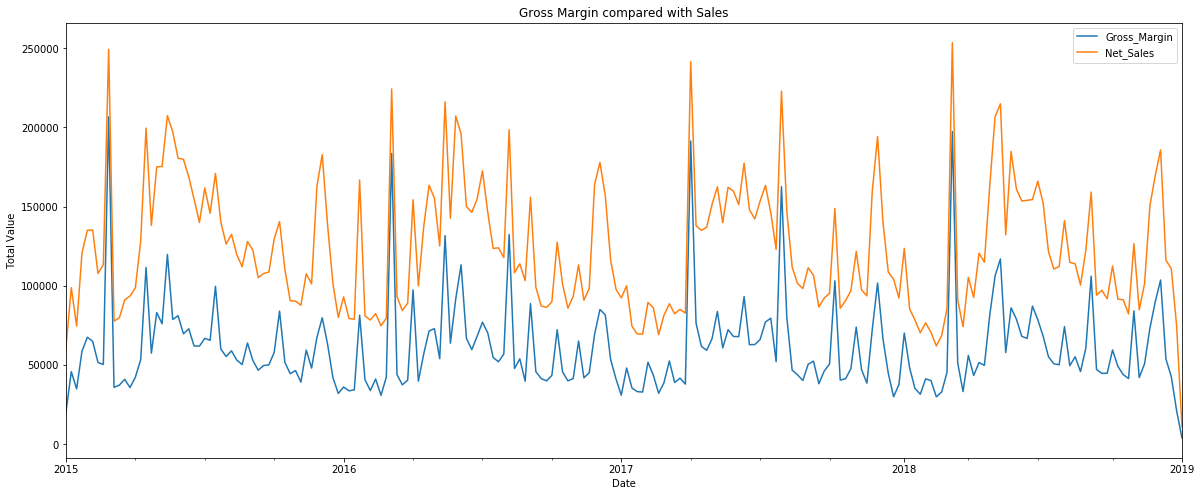

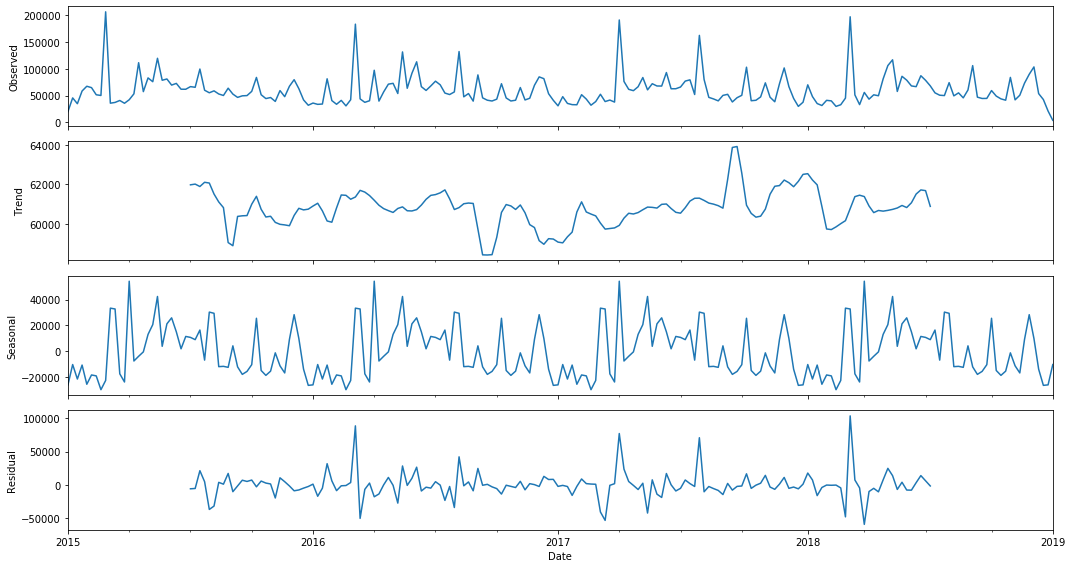

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:4546.880364134395
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:4171.625389458443
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:4074.247321517847
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:3720.4587600283458
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:4083.0327499284126
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:4028.2123359335105
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:3776.098919939227
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:3722.302571759393
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:4446.328662294557
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:4124.0226365999
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:4049.8497169366174
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:3704.1424496721334
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:4153.744894912567
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:4096.505597482337
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:3775.665496721833
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:3706.0161668880905
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:4328.138464103084
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:4018.620270478891
ARIMA(

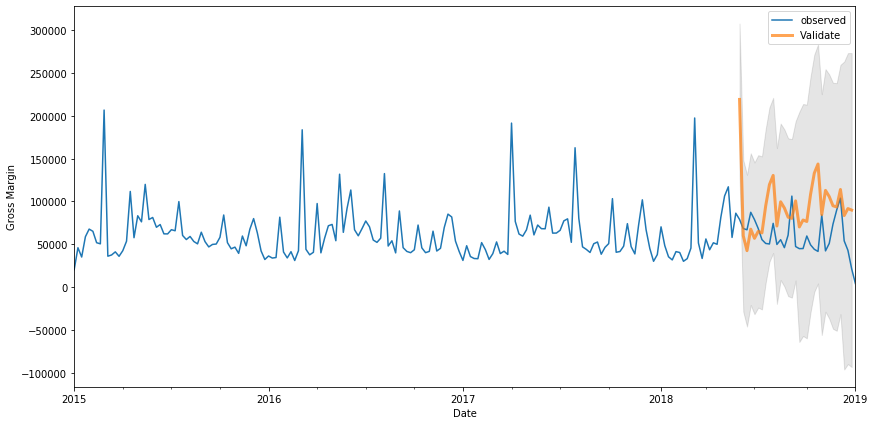

The Mean Squared Error of our validation is 2579379314.6
The Root Mean Squared Error of our validation is 50787.59


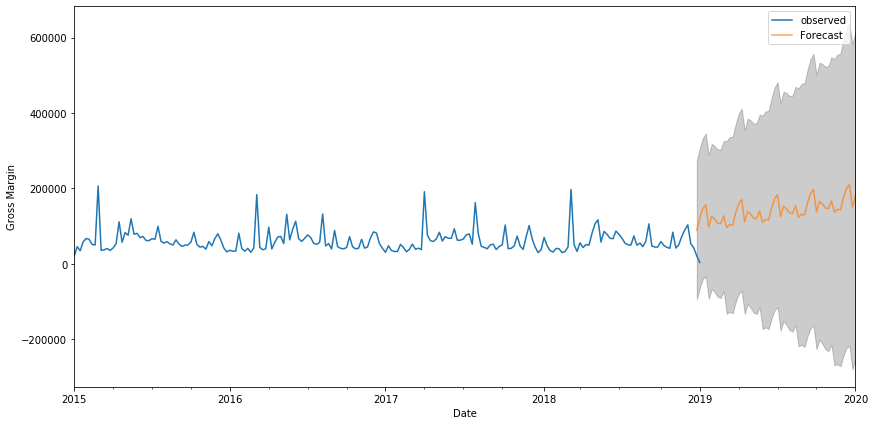

In [0]:
#Validate weekly
validate_start='2018-06-03'
validate_end='2018-12-30'
#Predict weekly
predict_start='2018-12-30'
predict_end='2020-01-05'
Forecast('W',validate_start,validate_end,predict_start,predict_end)


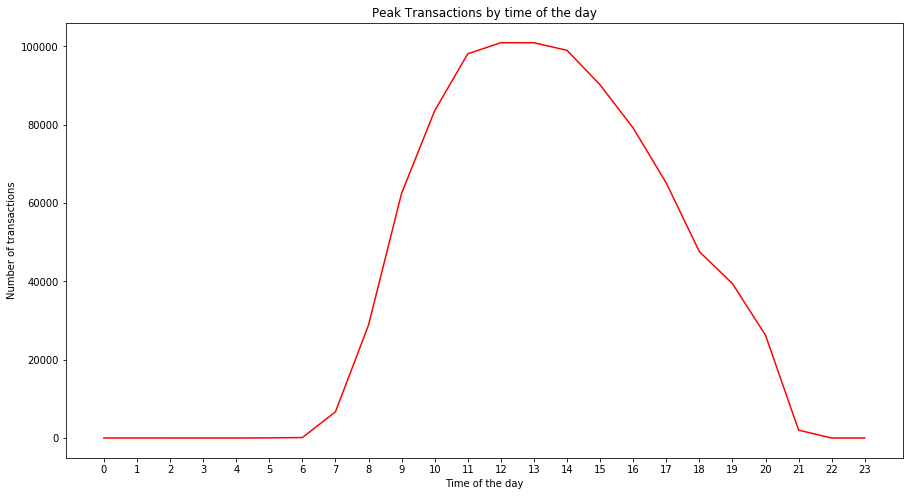

In [0]:
if not os.path.isdir('/content/drive/My Drive/DataScience/FinalProject/'+storeName):
    os.makedirs('/content/drive/My Drive/DataScience/FinalProject/'+storeName)
new_df=store_df.copy()
new_df['Transaction_Time']=pd.to_datetime(new_df['Transaction_Time'])
new_df['hour'] = new_df['Transaction_Time'].dt.hour
df_peakTransactions=new_df.groupby(['hour'])
peaktimings = df_peakTransactions.Receipt_Number.nunique().reset_index()
plt.plot(peaktimings.hour,peaktimings.Receipt_Number,color='r')
plt.xticks(range(24))
plt.xlabel('Time of the day')
plt.ylabel('Number of transactions')
plt.title('Peak Transactions by time of the day')
plt.savefig('/content/drive/My Drive/DataScience/FinalProject/'+storeName+'/PeakTransactionsbyTime.png', bbox_inches = "tight")
plt.show()

In [0]:
store_df.groupby(['Date','Receipt_Number']).count()

Transaction_Time  ...  Return_Code
Date       Receipt_Number                    ...             
2015-01-01 028009                         1  ...            1
           J52158                         1  ...            1
           J52159                         1  ...            1
           J52160                         5  ...            5
           J52161                         1  ...            1
...                                     ...  ...          ...
2018-12-31 A30762                         1  ...            1
           A30764                         1  ...            1
           A30765                         3  ...            3
           A30769                         3  ...            3
           A30770                         3  ...            3

[934714 rows x 36 columns]

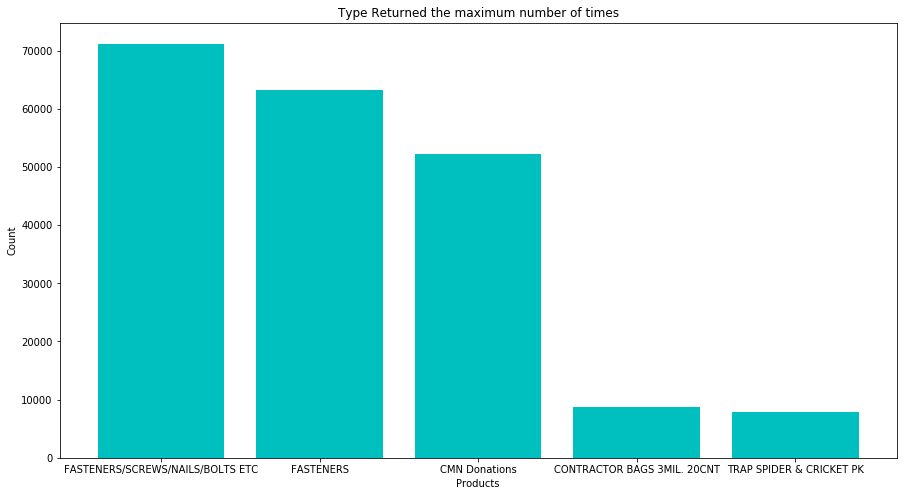

In [0]:
df=store_df.groupby('Item_Description')['Date'].count().sort_values(ascending=False).reset_index()
top_df=df.iloc[:5]
plt.bar(top_df.Item_Description,top_df.Date,color='c')
plt.xlabel('Products')
plt.ylabel('Count')
plt.title("Type Returned the maximum number of times")
plt.savefig('/content/drive/My Drive/DataScience/FinalProject/'+storeName+'/ProductsReturnedMaximum.png', bbox_inches = "tight")
plt.show()

In [0]:
os.makedirs('/content/drive/My Drive/DataScience/FinalProject/'+storeName+'___'+)

In [0]:
#####################Product time series####################
def productForecast(product,df,period,validate_start,validate_end,predict_start,predict_end):
  if not os.path.isdir('/content/drive/My Drive/DataScience/FinalProject/'+storeName+'___'+product):
    os.makedirs('/content/drive/My Drive/DataScience/FinalProject/'+storeName+'___'+product)
  y_NetSalesUnits  = df.Net_Sales_Units.resample(period).sum()
  #Plot Grossmargin compared with Sales
  y_NetSalesUnits.plot(figsize=(20, 8))
  plt.xlabel("Date")
  plt.ylabel("Total Units")
  plt.title("Sales Units time series")
  plt.legend()
  plt.savefig('/content/drive/My Drive/DataScience/FinalProject/'+storeName+'___'+product+'/Sales Units time Series.png', bbox_inches = "tight")
  plt.show()
  #Seasonal Decompose
  rcParams['figure.figsize'] = 15, 8
  decomposition = sm.tsa.seasonal_decompose(y_NetSalesUnits, model='additive')  
  fig = decomposition.plot()
  plt.savefig('/content/drive/My Drive/DataScience/FinalProject/'+storeName+'___'+product+'/decomposition.png', bbox_inches = "tight")
  plt.show()
  #Sarimax  model fitting
  p = d = q = range(0, 2)
  pdq = list(itertools.product(p, d, q))
  seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
  #split data into training data
  y_NetSalesUnits_train=y_NetSalesUnits['2015-01-01':'2018-06']
  ##############################
  for param in pdq:
      for param_seasonal in seasonal_pdq:
          try:
              mod = sm.tsa.statespace.SARIMAX(y_NetSalesUnits_train,
                                              order=param,
                                              seasonal_order=param_seasonal,
                                              enforce_stationarity=False,
                                              enforce_invertibility=False)
              results = mod.fit()
              print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
          except:
              continue
  # Optimal values of p,d and q ->ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:26.099158099099753
  #ARIMA(0, 1, 1)x(0, 1, 0, 12)12 - AIC:231.22919432787555
  mod = sm.tsa.statespace.SARIMAX(y_NetSalesUnits_train,
                                  order=(0, 1, 1),
                                  seasonal_order=(0, 1, 0, 12),
                                  enforce_stationarity=False,
                                  enforce_invertibility=False)
  results = mod.fit()
  print(results.summary())
  ##Plot Diagnostics
  #error
  #results.plot_diagnostics(figsize=(16, 8))
  #plt.savefig('/content/drive/My Drive/DataScience/FinalProject/'+storeName+'___'+product+'/diagnostics.png', bbox_inches = "tight")
  #plt.show()

  #Validate model 
  #Used  data from 2018 onwards to validate the model by comparing the observed and the predicted
  pred = results.get_prediction(start=pd.to_datetime(validate_start),end= pd.to_datetime(validate_end), dynamic=False)
  pred_ci = pred.conf_int()
  ax = y_NetSalesUnits['2015':].plot(label='observed')
  pred.predicted_mean.plot(ax=ax, label='Validate', alpha=.7, figsize=(14, 7),linewidth=3)
  ax.fill_between(pred_ci.index,
                  pred_ci.iloc[:, 0],
                  pred_ci.iloc[:, 1], color='k', alpha=.1)
  ax.set_xlabel('Date')
  ax.set_ylabel('Net Sales Units')
  plt.title("Validation model for Net Sales Unit for the Product")
  plt.legend()
  plt.savefig('/content/drive/My Drive/DataScience/FinalProject/'+storeName+'___'+product+'/validate.png', bbox_inches = "tight")
  plt.show()
  #Validation error handling
  y_forecasted = pred.predicted_mean
  y_truth = y_NetSalesUnits['2018-01-01':]
  mse = ((y_forecasted - y_truth) ** 2).mean()
  print('The Mean Squared Error of our validation is {}'.format(round(mse, 2)))
  print('The Root Mean Squared Error of our validation is {}'.format(round(np.sqrt(mse), 2)))

  #forecasting or predicting for future and connecting it to previous ggraph
  pred = results.get_prediction(start=pd.to_datetime(predict_start),end=predict_end, dynamic=False)
  pred_ci = pred.conf_int()
  ax = y_NetSalesUnits['2015':].plot(label='observed')
  pred.predicted_mean.plot(ax=ax, label='Forecasted Stocks', alpha=.7, figsize=(14, 7))
  ax.fill_between(pred_ci.index,
                  pred_ci.iloc[:, 0],
                  pred_ci.iloc[:, 1], color='k', alpha=.2)
  ax.set_xlabel('Date')
  ax.set_ylabel('Stocks')
  plt.title("Forecasted Stocks for the Product")
  plt.legend()
  plt.savefig('/content/drive/My Drive/DataScience/FinalProject/'+storeName+'___'+product+'/Forecast.png', bbox_inches = "tight")
  plt.show()

In [0]:
#selecting top 3 net sale units products 
productTimeSeries_df = store_df.filter(['Date','Item_Description','Net_Sales_Units'])
topProducts = productTimeSeries_df.groupby('Item_Description').Net_Sales_Units.sum().sort_values(ascending=False).index[:4].tolist()
topProducts = topProducts[:2]+[topProducts[-1]]
topProducts

['FASTENERS/SCREWS/NAILS/BOLTS ETC', 'FASTENERS', 'CMN Donations']

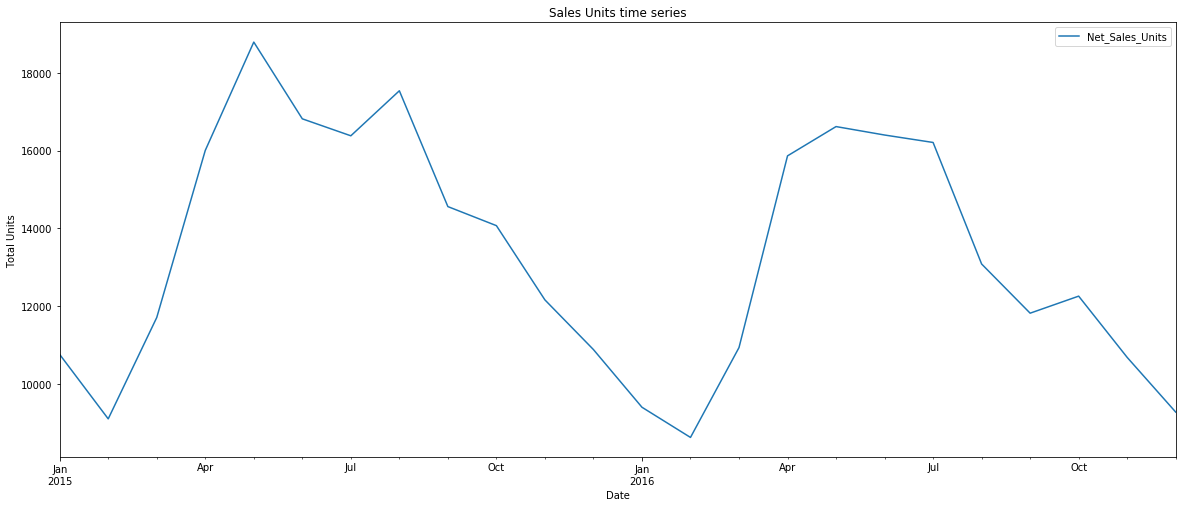

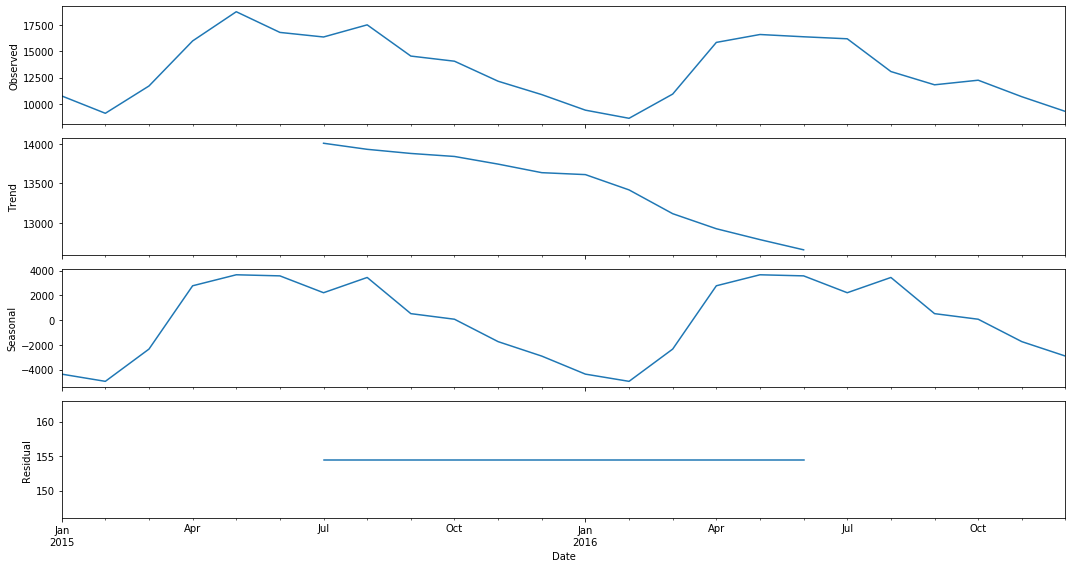

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:505.694564076472
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:199.70367155841865
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:207.12734723081144
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:459.8481647801836
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:181.86512561975508
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:209.1221494532818
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:402.0993020573386
ARIMA(0, 1, 0)x(0, 1, 0, 12)12 - AIC:179.5288088436727
ARIMA(0, 1, 0)x(1, 0, 0, 12)12 - AIC:195.67293994068453
ARIMA(0, 1, 1)x(0, 0, 0, 12)12 - AIC:379.59151270395927
ARIMA(0, 1, 1)x(0, 1, 0, 12)12 - AIC:162.16408388670612
ARIMA(0, 1, 1)x(1, 0, 0, 12)12 - AIC:196.59155939402854
ARIMA(1, 0, 0)x(0, 0, 0, 12)12 - AIC:421.64698151909204
ARIMA(1, 0, 0)x(0, 1, 0, 12)12 - AIC:196.30982736055984
ARIMA(1, 0, 0)x(1, 0, 0, 12)12 - AIC:192.93734707251267
ARIMA(1, 0, 1)x(0, 0, 0, 12)12 - AIC:401.42396686575853
ARIMA(1, 0, 1)x(0, 1, 0, 12)12 - AIC:181.1949267666429
ARIMA(1, 0, 1)x(1, 0, 0, 12)12 - AIC:197.38521325908653

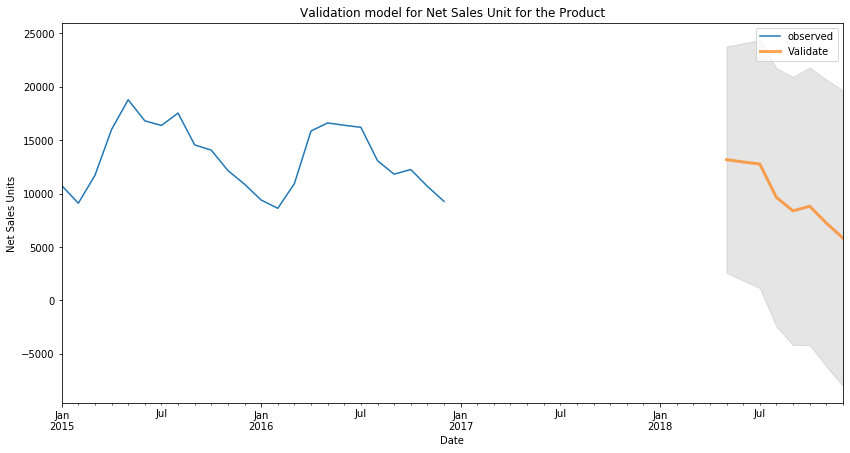

The Mean Squared Error of our validation is nan
The Root Mean Squared Error of our validation is nan


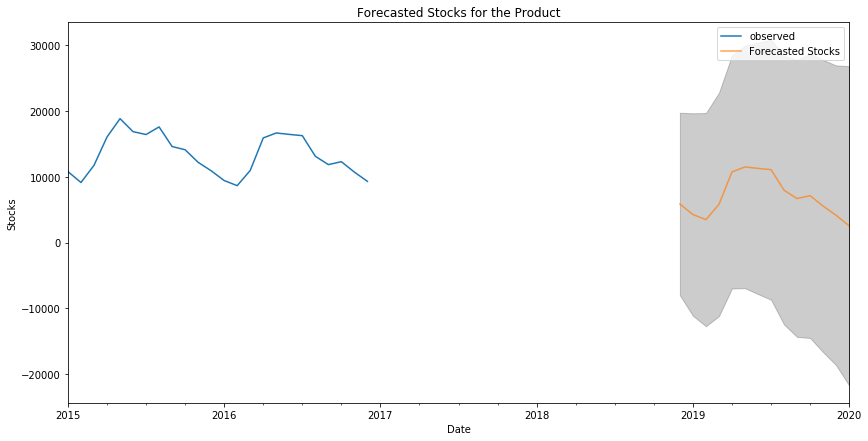

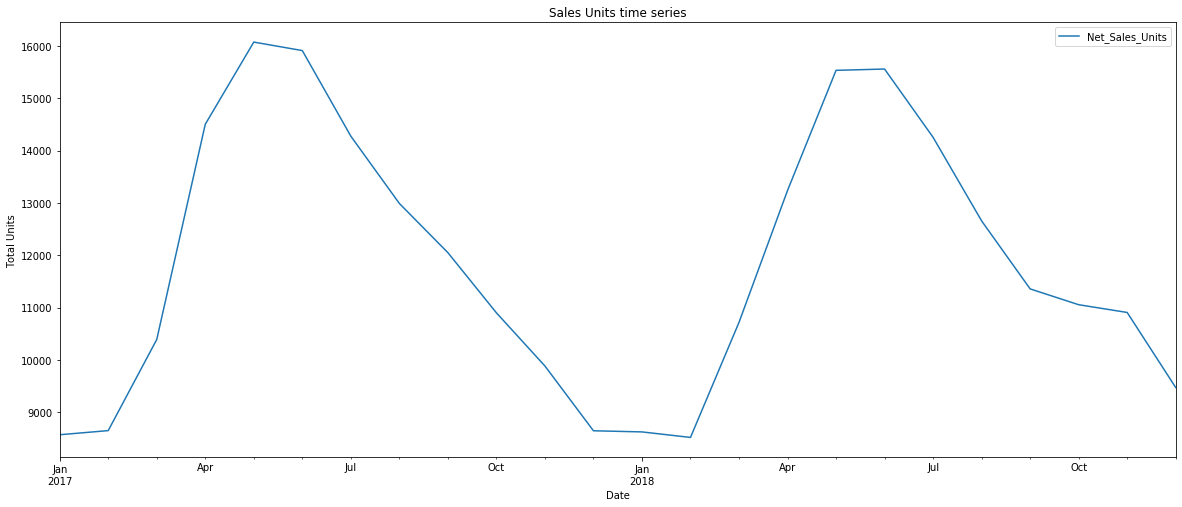

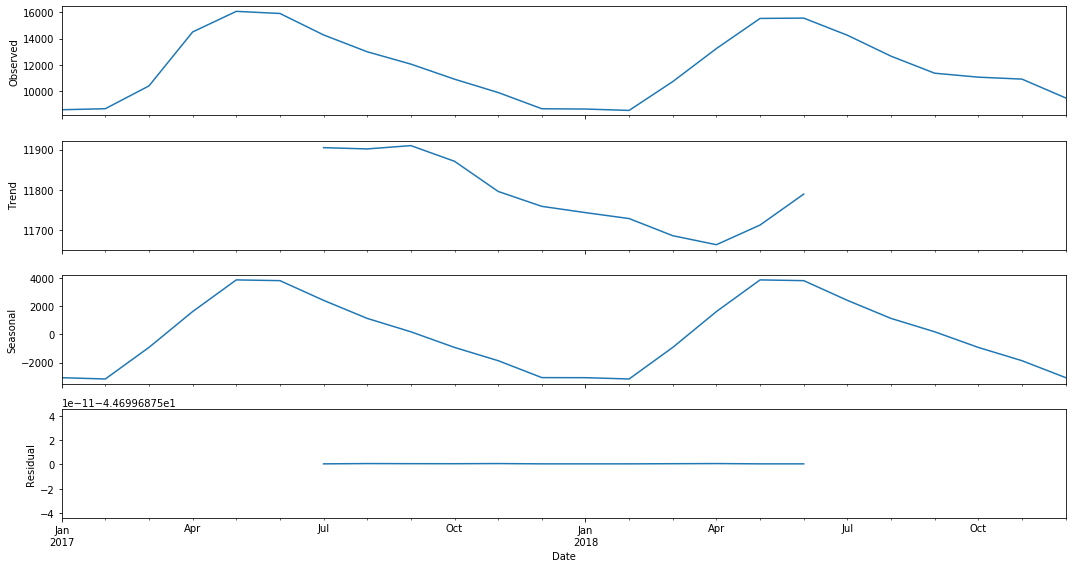

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:370.8456941138759
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:81.02878188899578
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:94.41368932677656
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:340.17804471999676
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:67.94069316975792
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:130.11490052446499
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:286.0484295809221
ARIMA(0, 1, 0)x(0, 1, 0, 12)12 - AIC:67.85647248871243
ARIMA(0, 1, 0)x(1, 0, 0, 12)12 - AIC:83.54691743723328
ARIMA(0, 1, 1)x(0, 0, 0, 12)12 - AIC:262.22253013152647
ARIMA(0, 1, 1)x(0, 1, 0, 12)12 - AIC:53.47343917570976
ARIMA(0, 1, 1)x(1, 0, 0, 12)12 - AIC:84.96165999830386
ARIMA(1, 0, 0)x(0, 0, 0, 12)12 - AIC:304.24157150409013
ARIMA(1, 0, 0)x(0, 1, 0, 12)12 - AIC:82.83122058607427
ARIMA(1, 0, 0)x(1, 0, 0, 12)12 - AIC:84.83979530597041
ARIMA(1, 0, 1)x(0, 0, 0, 12)12 - AIC:282.0617077030446
ARIMA(1, 0, 1)x(0, 1, 0, 12)12 - AIC:69.84833491274746
ARIMA(1, 0, 1)x(1, 0, 0, 12)12 - AIC:81.24414346934522
ARIMA(

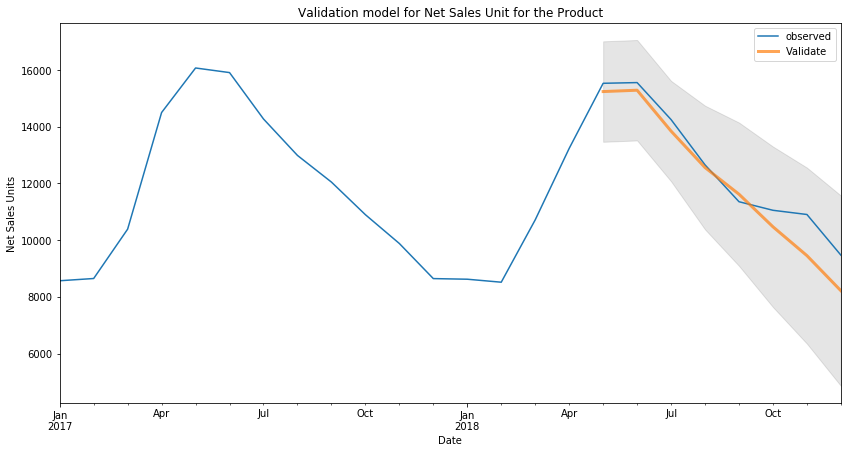

The Mean Squared Error of our validation is 553099.57
The Root Mean Squared Error of our validation is 743.71


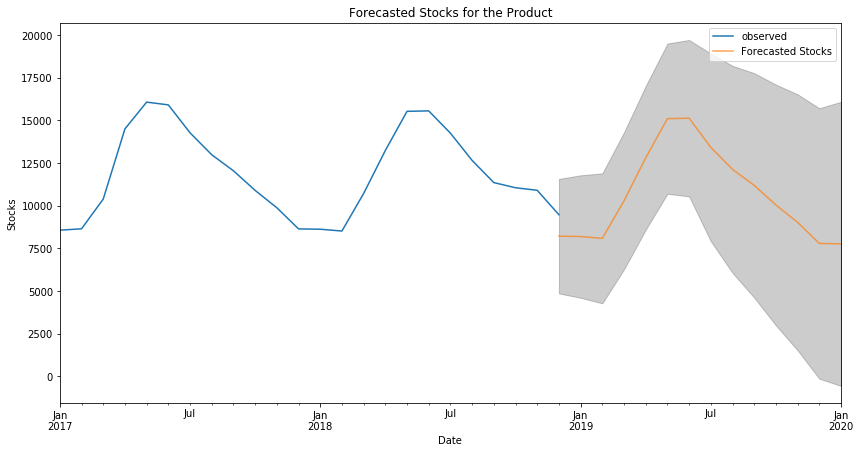

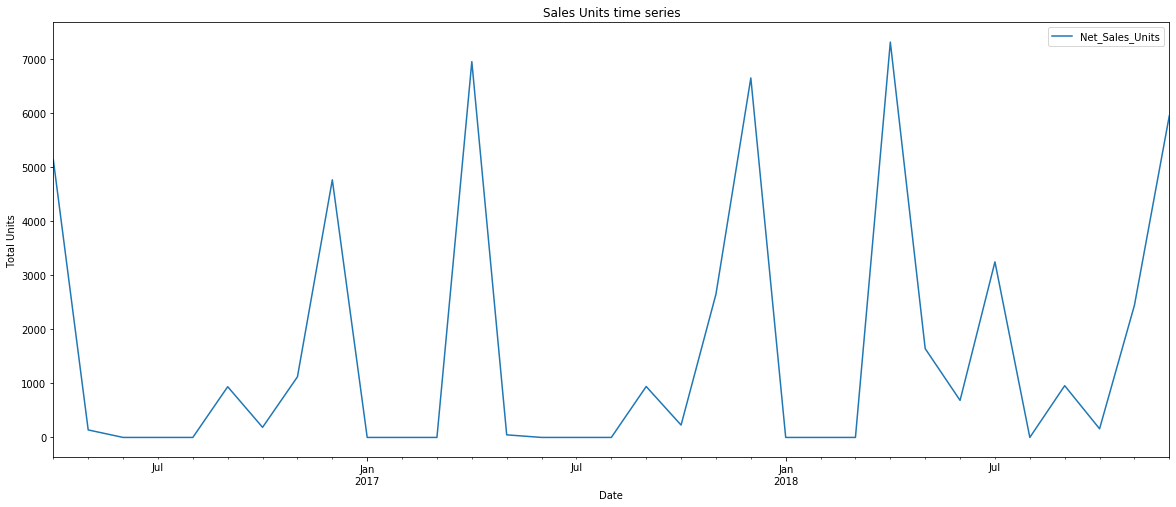

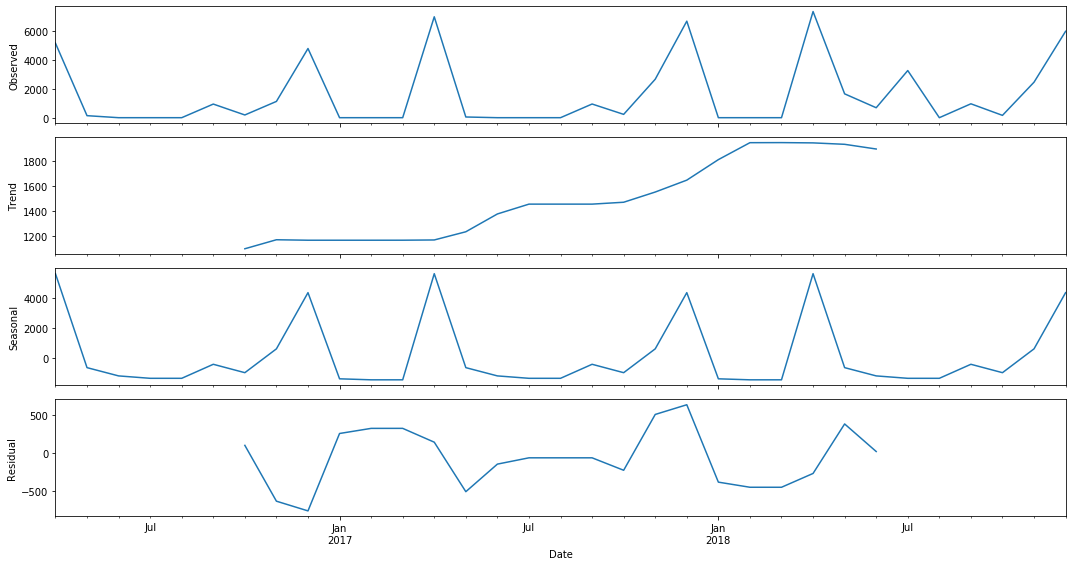

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:485.6326761085581
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:229.04991671564252
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:242.8359696996152
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:54.02881402044206
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:469.0923898354311
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:210.49438382333855
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:244.8232047752233
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:53.68585380430389
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:479.5062047316907
ARIMA(0, 1, 0)x(0, 1, 0, 12)12 - AIC:212.8005625854701
ARIMA(0, 1, 0)x(1, 0, 0, 12)12 - AIC:233.23048305331793
ARIMA(0, 1, 0)x(1, 1, 0, 12)12 - AIC:35.27154793805276
ARIMA(0, 1, 1)x(0, 0, 0, 12)12 - AIC:450.07282181118035
ARIMA(0, 1, 1)x(0, 1, 0, 12)12 - AIC:197.20412744348306
ARIMA(0, 1, 1)x(1, 0, 0, 12)12 - AIC:228.78165177910333
ARIMA(0, 1, 1)x(1, 1, 0, 12)12 - AIC:36.69382926340486
ARIMA(1, 0, 0)x(0, 0, 0, 12)12 - AIC:486.60048237785065
ARIMA(1, 0, 0)x(0, 1, 0, 12)12 - AIC:228.19621236591308
AR

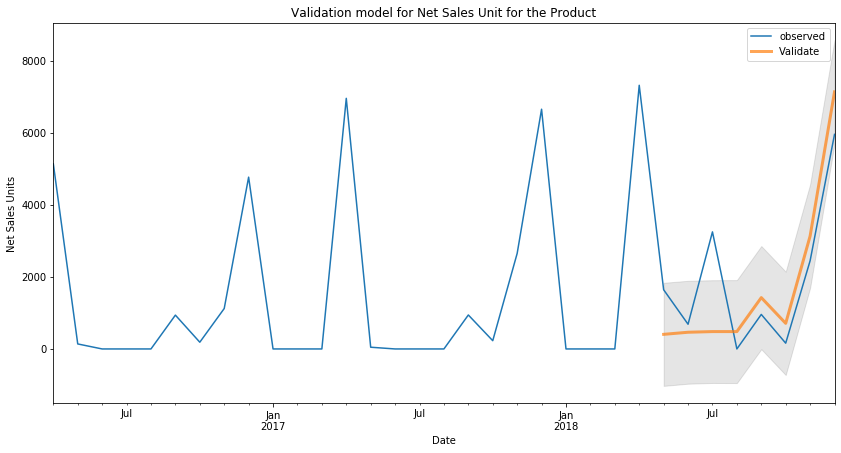

The Mean Squared Error of our validation is 1482821.31
The Root Mean Squared Error of our validation is 1217.71


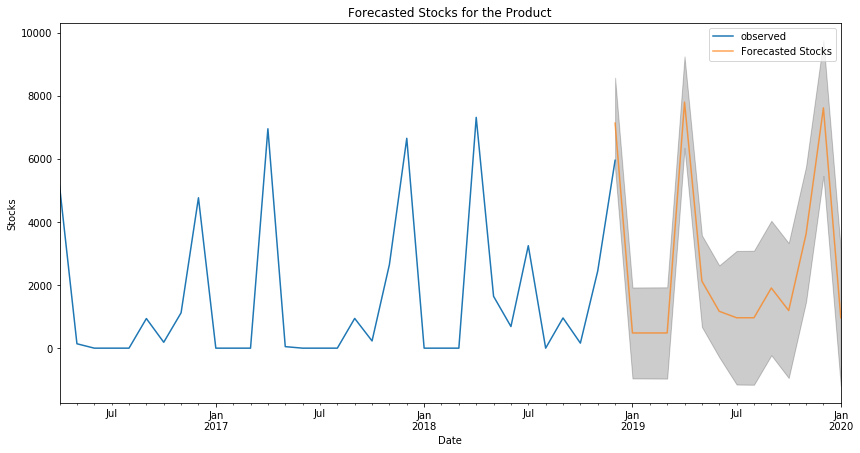

In [0]:
for product in topProducts:
  df = productTimeSeries_df[productTimeSeries_df['Item_Description']==product]
  df = df.filter(['Date','Net_Sales_Units'])
  df = df.sort_values('Date')
  df.groupby('Date')
  df=df.set_index('Date')
  #validate for product monthly
  validate_start='2018-05-01'
  validate_end='2018-12-01'
  #predict for product monthly
  predict_start='2018-12-01'
  predict_end='2020-01-01'
  productForecast(product,df,'MS',validate_start,validate_end,predict_start,predict_end)

In [0]:
########Cleaning##############
##########new report start
#Drop *5 customer number rows
store_df.drop(store_df[store_df['Customer_Number'].str.startswith('*5')].index,inplace=True)

In [0]:
#Data frame for recency score mapped with each customer number
customer_recency = pd.DataFrame(store_df['Customer_Number'].unique())
customer_recency.columns=['Customer_Number']

#Get latest date for each customer transaction
latest_purchase_date = store_df.groupby('Customer_Number').Date.max().reset_index()
latest_purchase_date.columns = ['Customer_Number','Latest_purchase_date']


In [0]:
#Recency score calculation
latest_purchase_date['Recency'] = (latest_purchase_date['Latest_purchase_date'].max() - latest_purchase_date['Latest_purchase_date']).dt.days
#merge this dataframe to customer dataframe on cutsomer_number
customer_recency = pd.merge(customer_recency, latest_purchase_date[['Customer_Number','Recency']], on='Customer_Number')

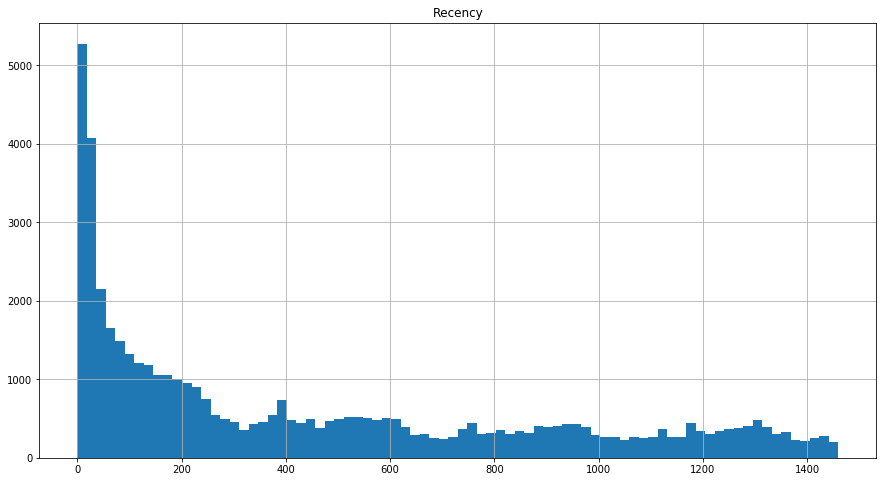

In [0]:
customer_recency.hist(bins=80)
plt.savefig('/content/drive/My Drive/DataScience/FinalProject/'+storeName+'/Recency.png', bbox_inches = "tight")

In [0]:
#Finding optimal clusters for KMeans based on Recency,Frequency,Monetary Value
def OptimalClusters(parameter):
  sse={}
  parameter = customer_recency[[parameter]]
  for k in range(1, 10):
      kmeans = KMeans(n_clusters=k, max_iter=1000).fit(parameter)
      parameter["clusters"] = kmeans.labels_
      sse[k] = kmeans.inertia_ 
  plt.figure(figsize=(15,8))
  plt.plot(list(sse.keys()), list(sse.values()))
  plt.xlabel("Number of cluster")
  plt.title('Inertia Graph')
  plt.savefig('/content/drive/My Drive/DataScience/FinalProject/'+storeName+'/Inertia_Graph.png', bbox_inches = "tight")
  plt.show()

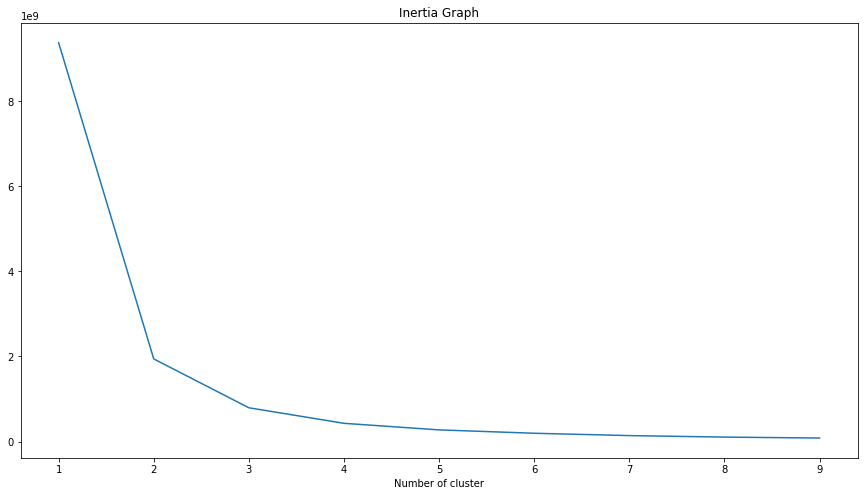

In [0]:
#Optimal clusters for recency
OptimalClusters('Recency')

In [0]:
#build 4 clusters for recency and add it to dataframe
def Initialize(parameter):
  kmeans = KMeans(n_clusters=4)
  kmeans.fit(customer_recency[[parameter]])
  new_parameter_name=parameter+'Cluster'
  customer_recency[new_parameter_name] = kmeans.predict(customer_recency[[parameter]])

#function for ordering cluster numbers
def order_cluster(cluster_field_name, target_field_name,df,ascending):
    new_cluster_field_name = 'new_' + cluster_field_name
    df_new = df.groupby(cluster_field_name)[target_field_name].mean().reset_index()
    df_new = df_new.sort_values(by=target_field_name,ascending=ascending).reset_index(drop=True)
    df_new['index'] = df_new.index
    df_final = pd.merge(df,df_new[[cluster_field_name,'index']], on=cluster_field_name)
    df_final = df_final.drop([cluster_field_name],axis=1)
    df_final = df_final.rename(columns={"index":cluster_field_name})
    return df_final
Initialize('Recency')
customer_recency = order_cluster('RecencyCluster', 'Recency',customer_recency,False)

In [0]:
#In above function we got customers clustered based  on recency score,where 3rd cluster is the most recent. 
customer_recency[customer_recency['RecencyCluster']==3]
customer_recency.groupby('RecencyCluster')['Recency'].describe()

,count,mean,std,min,25%,50%,75%,max
RecencyCluster,,,,,,,,
0,6908.0,1256.510278,105.875134,1063.0,1172.0,1260.0,1338.0,1460.0
1,7101.0,868.099423,105.810346,671.0,775.0,875.0,955.0,1062.0
2,9921.0,471.407519,107.192489,282.0,383.0,471.0,563.0,670.0
3,24874.0,90.800233,79.634275,0.0,22.0,65.0,151.0,281.0


In [0]:
#Customer Frequency calculation
customer_frequency = store_df.groupby('Customer_Number').Date.count().reset_index()
customer_frequency.columns = ['Customer_Number','Frequency']

#adding this data to our main dataframe
customer_recency = pd.merge(customer_recency, customer_frequency, on='Customer_Number')


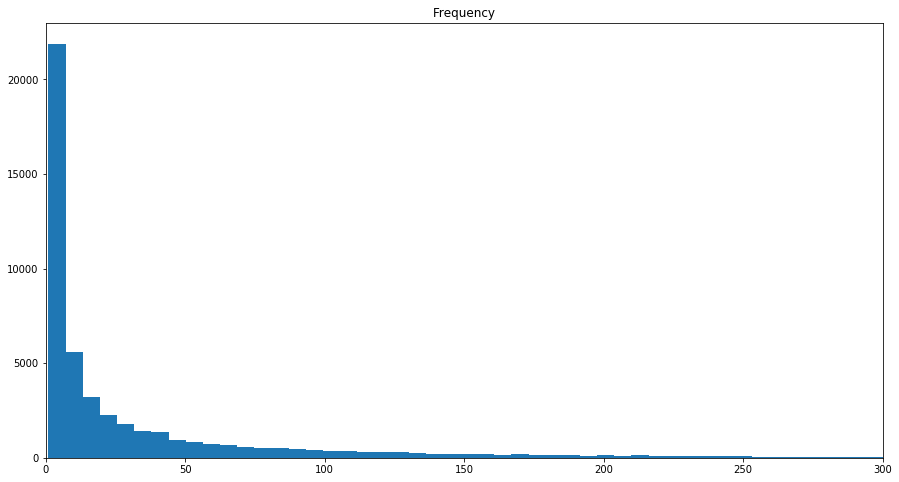

In [0]:
plt.hist(x=customer_recency.query('Frequency < 5000')['Frequency'],bins=500)
plt.xlim(0,300)
plt.title("Frequency")
plt.savefig('/content/drive/My Drive/DataScience/FinalProject/'+storeName+'/Frequency.png', bbox_inches = "tight")


In [0]:
Initialize('Frequency')
customer_recency = order_cluster('FrequencyCluster', 'Frequency',customer_recency,True)

In [0]:
#high frequency number means better customers.
customer_recency.groupby('FrequencyCluster')['Frequency'].describe()

In [0]:
#calculate revenue for each customer
customer_revenue = store_df.groupby('Customer_Number')['Gross_Margin'].sum().reset_index()

#merge it with our main dataframe
customer_recency = pd.merge(customer_recency, customer_revenue, on='Customer_Number')

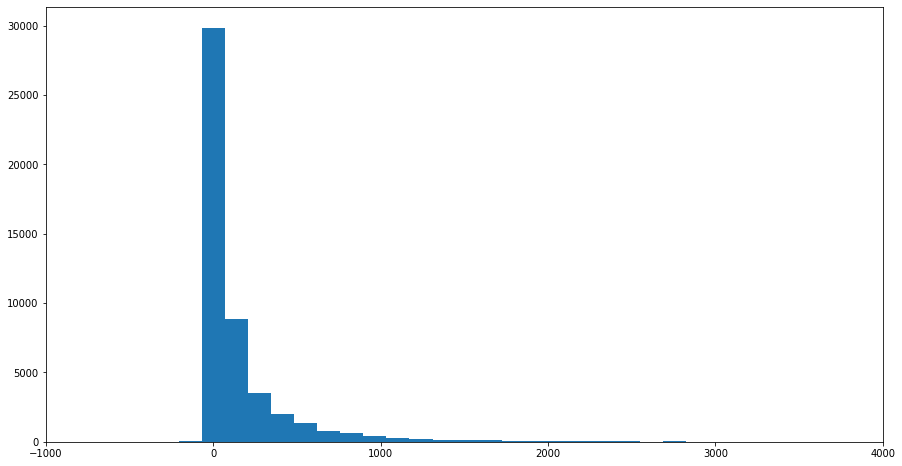

In [0]:
plt.hist(x=customer_recency['Gross_Margin'],bins=20000)
plt.xlim(-1000,4000)
plt.savefig('/content/drive/My Drive/DataScience/FinalProject/'+storeName+'/Revenue.png', bbox_inches = "tight")

In [0]:
Initialize('Gross_Margin')
customer_recency = order_cluster('Gross_MarginCluster', 'Gross_Margin',customer_recency,True)
customer_recency.groupby('Gross_MarginCluster')['Gross_Margin'].describe()

,count,mean,std,min,25%,50%,75%,max
Gross_MarginCluster,,,,,,,,
0,48760.0,1.671858e+02,422.222168,-4472.80,10.970,39.06,158.225,14100.00
1,28.0,2.952804e+04,9534.144392,15900.00,20397.995,29968.75,37046.875,46950.00
2,15.0,7.146865e+04,21564.188309,52550.00,58755.000,61862.00,77500.240,129000.00
3,1.0,2.749629e+06,NaN,2749629.22,2749629.220,2749629.22,2749629.220,2749629.22


In [0]:
#calculate RFM score  
customer_recency['RFMScore'] = customer_recency['RecencyCluster'] + customer_recency['FrequencyCluster'] + customer_recency['Gross_MarginCluster']
customer_recency.groupby('RFMScore')['Recency','Frequency','Gross_Margin'].mean()

,Recency,Frequency,Gross_Margin
RFMScore,,,
0,1256.541793,5.201217,2.581797e+01
1,868.541220,8.348391,4.888583e+01
2,472.316397,13.183603,7.554645e+01
3,101.896144,36.614551,1.602556e+02
4,31.353953,250.056865,1.230314e+03
5,112.750000,30.500000,7.264025e+04
7,0.000000,13065.000000,5.657324e+04
9,0.000000,551339.000000,2.749629e+06


In [0]:
#Divide cutomers based on the score
customer_recency['Segment'] = 'Low-Value'
customer_recency.loc[customer_recency['RFMScore']>2,'Segment'] = 'Mid-Value' 
customer_recency.loc[customer_recency['RFMScore']>4,'Segment'] = 'High-Value' 

In [0]:
import plotly as py
import plotly.offline as pyoff
import plotly.graph_objs as go
import plotly.io as pio
pyoff.init_notebook_mode(connected=True)

In [0]:
# import plotly.io as pio

pio.renderers.default = "colab"
pio.renderers

Renderers configuration
-----------------------
    Default renderer: 'colab'
    Available renderers:
        ['plotly_mimetype', 'jupyterlab', 'nteract', 'vscode',
         'notebook', 'notebook_connected', 'kaggle', 'azure', 'colab',
         'cocalc', 'databricks', 'json', 'png', 'jpeg', 'jpg', 'svg',
         'pdf', 'browser', 'firefox', 'chrome', 'chromium', 'iframe',
         'iframe_connected', 'sphinx_gallery']

In [0]:
def configure_plotly_browser_state():
  import IPython
  display(IPython.core.display.HTML('''
        <script src="/static/components/requirejs/require.js"></script>
        <script>
          requirejs.config({
            paths: {
              base: '/static/base',
              plotly: 'https://cdn.plot.ly/plotly-latest.min.js?noext',
            },
          });
        </script>
        '''))

In [0]:
configure_plotly_browser_state()
def PlotGraph_scatter(feature1,feature2):
#Revenue vs Frequency plots 
  customer_recency_graph = customer_recency.query("Gross_Margin < 2000000 and Frequency < 400000")
  plot_data = [
      go.Scatter(
          x=customer_recency_graph.query("Segment == 'Low-Value'")[feature1],
          y=customer_recency_graph.query("Segment == 'Low-Value'")[feature2],
          mode='markers',
          name='Low',
          marker= dict(size= 7,
              line= dict(width=1),
              color= 'blue',
              opacity= 0.8
            )
      ),
          go.Scatter(
          x=customer_recency_graph.query("Segment == 'Mid-Value'")[feature1],
          y=customer_recency_graph.query("Segment == 'Mid-Value'")[feature2],
          mode='markers',
          name='Mid',
          marker= dict(size= 9,
              line= dict(width=1),
              color= 'green',
              opacity= 0.5
            )
      ),
          go.Scatter(
          x=customer_recency_graph.query("Segment == 'High-Value'")[feature1],
          y=customer_recency_graph.query("Segment == 'High-Value'")[feature2],
          mode='markers',
          name='High',
          marker= dict(size= 11,
              line= dict(width=1),
              color= 'red',
              opacity= 0.9
            )
      ),
  ]

  plot_layout = go.Layout(
          yaxis= {'title': feature2},
          xaxis= {'title': feature1},
          title='Segments'
      )
  fig = go.Figure(data=plot_data, layout=plot_layout)
  pyoff.iplot(fig)
PlotGraph_scatter('Frequency','Gross_Margin')


In [0]:

#Revenue Recency
tx_graph = customer_recency.query("Gross_Margin < 2000000 and Frequency < 400000")
# tx_graph = customer_recency
plot_data = [
    go.Scatter(
        x=tx_graph.query("Segment == 'Low-Value'")['Recency'],
        y=tx_graph.query("Segment == 'Low-Value'")['Gross_Margin'],
        mode='markers',
        name='Low',
        marker= dict(size= 7,
            line= dict(width=1),
            color= 'blue',
            opacity= 0.8
           )
    ),
        go.Scatter(
        x=tx_graph.query("Segment == 'Mid-Value'")['Recency'],
        y=tx_graph.query("Segment == 'Mid-Value'")['Gross_Margin'],
        mode='markers',
        name='Mid',
        marker= dict(size= 9,
            line= dict(width=1),
            color= 'green',
            opacity= 0.5
           )
    ),
        go.Scatter(
        x=tx_graph.query("Segment == 'High-Value'")['Recency'],
        y=tx_graph.query("Segment == 'High-Value'")['Gross_Margin'],
        mode='markers',
        name='High',
        marker= dict(size= 11,
            line= dict(width=1),
            color= 'red',
            opacity= 0.9
           )
    ),
]

plot_layout = go.Layout(
        yaxis= {'title': "Gross_Margin"},
        xaxis= {'title': "Recency"},
        title='Segments'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

In [0]:
# Revenue vs Frequency
tx_graph = customer_recency.query("Gross_Margin < 2000000 and Frequency < 400000")
# tx_graph = customer_recency
plot_data = [
    go.Scatter(
        x=tx_graph.query("Segment == 'Low-Value'")['Recency'],
        y=tx_graph.query("Segment == 'Low-Value'")['Frequency'],
        mode='markers',
        name='Low',
        marker= dict(size= 7,
            line= dict(width=1),
            color= 'blue',
            opacity= 0.8
           )
    ),
        go.Scatter(
        x=tx_graph.query("Segment == 'Mid-Value'")['Recency'],
        y=tx_graph.query("Segment == 'Mid-Value'")['Frequency'],
        mode='markers',
        name='Mid',
        marker= dict(size= 9,
            line= dict(width=1),
            color= 'green',
            opacity= 0.5
           )
    ),
        go.Scatter(
        x=tx_graph.query("Segment == 'High-Value'")['Recency'],
        y=tx_graph.query("Segment == 'High-Value'")['Frequency'],
        mode='markers',
        name='High',
        marker= dict(size= 11,
            line= dict(width=1),
            color= 'red',
            opacity= 0.9
           )
    ),
]

plot_layout = go.Layout(
        yaxis= {'title': "Frequency"},
        xaxis= {'title': "Recency"},
        title='Segments'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

In [0]:
###New Topic ->>>>>>>>>>>>>>>>>>>Life time value  
import datetime 
#create 3m and 6m dataframes
tx_3m = store_df[(store_df.Date > datetime.date(2017,1,1)) & (store_df.Date <= datetime.date(2018,6,1))].reset_index(drop=True)   #training
tx_6m = store_df[(store_df.Date > datetime.date(2018,6,1)) & (store_df.Date <= datetime.date(2018,12,31))].reset_index(drop=True) #testing

In [0]:
#create tx_user for assigning clustering
tx_user = pd.DataFrame(tx_3m['Customer_Number'].unique())
tx_user.columns = ['Customer_Number']

In [0]:
#calculate recency score
tx_max_purchase = tx_3m.groupby('Customer_Number').Date.max().reset_index()
tx_max_purchase.columns = ['Customer_Number','MaxPurchaseDate']
tx_max_purchase['Recency'] = (tx_max_purchase['MaxPurchaseDate'].max() - tx_max_purchase['MaxPurchaseDate']).dt.days
tx_user = pd.merge(tx_user, tx_max_purchase[['Customer_Number','Recency']], on='Customer_Number')

In [0]:
kmeans = KMeans(n_clusters=4)
kmeans.fit(tx_user[['Recency']])
tx_user['RecencyCluster'] = kmeans.predict(tx_user[['Recency']])
tx_user = order_cluster('RecencyCluster', 'Recency',tx_user,False)

In [0]:
#calcuate frequency score
tx_frequency = tx_3m.groupby('Customer_Number').Date.count().reset_index()
tx_frequency.columns = ['Customer_Number','Frequency']
tx_user = pd.merge(tx_user, tx_frequency, on='Customer_Number')

kmeans = KMeans(n_clusters=4)
kmeans.fit(tx_user[['Frequency']])
tx_user['FrequencyCluster'] = kmeans.predict(tx_user[['Frequency']])

tx_user = order_cluster('FrequencyCluster', 'Frequency',tx_user,True)

In [0]:
#calcuate revenue score
#tx_3m['Revenue'] = tx_3m['UnitPrice'] * tx_3m['Quantity']
tx_revenue = tx_3m.groupby('Customer_Number')['Gross_Margin'].sum().reset_index()
tx_user = pd.merge(tx_user, tx_revenue, on='Customer_Number')

kmeans = KMeans(n_clusters=4)
kmeans.fit(tx_user[['Gross_Margin']])
tx_user['RevenueCluster'] = kmeans.predict(tx_user[['Gross_Margin']])
tx_user = order_cluster('RevenueCluster', 'Gross_Margin',tx_user,True)

In [0]:
#overall scoring
tx_user['OverallScore'] = tx_user['RecencyCluster'] + tx_user['FrequencyCluster'] + tx_user['RevenueCluster']
tx_user['Segment'] = 'Low-Value'
tx_user.loc[tx_user['OverallScore']>2,'Segment'] = 'Mid-Value' 
tx_user.loc[tx_user['OverallScore']>4,'Segment'] = 'High-Value' 

In [0]:
#calculate revenue and create a new dataframe for it
tx_user_6m = tx_6m.groupby('Customer_Number')['Gross_Margin'].sum().reset_index()
tx_user_6m.columns = ['Customer_Number','m6_Revenue']

In [0]:
tx_user_6m['m6_Revenue'].head()

0       1.22
1       8.25
2    1450.38
3    1273.84
4      27.08
Name: m6_Revenue, dtype: float64

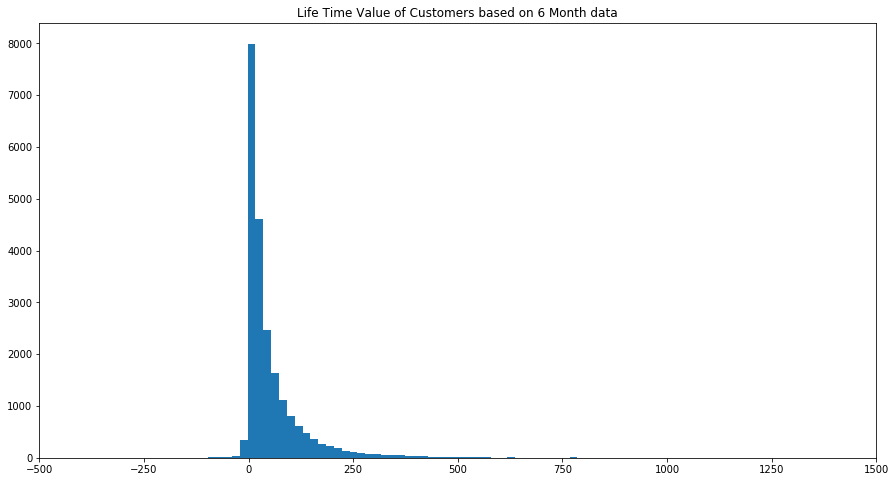

In [0]:
#plot LTV histogram
plt.hist(x=tx_user_6m['m6_Revenue'],bins=20000)
plt.xlim(-500,1500)
plt.title("Life Time Value of Customers tested on 6 Month data")
plt.savefig('/content/drive/My Drive/DataScience/FinalProject/'+storeName+'/LTV_6mRevenue.png', bbox_inches = "tight")

In [0]:
tx_merge = pd.merge(tx_user, tx_user_6m, on='Customer_Number', how='left')
tx_merge = tx_merge.fillna(0)

tx_graph = tx_merge.query("m6_Revenue < 300000")
plot_data = [
    go.Scatter(
        x=tx_graph.query("Segment == 'Low-Value'")['OverallScore'],
        y=tx_graph.query("Segment == 'Low-Value'")['m6_Revenue'],
        mode='markers',
        name='Low',
        marker= dict(size= 7,
            line= dict(width=1),
            color= 'blue',
            opacity= 0.8
           )
    ),
        go.Scatter(
        x=tx_graph.query("Segment == 'Mid-Value'")['OverallScore'],
        y=tx_graph.query("Segment == 'Mid-Value'")['m6_Revenue'],
        mode='markers',
        name='Mid',
        marker= dict(size= 9,
            line= dict(width=1),
            color= 'green',
            opacity= 0.5
           )
    ),
        go.Scatter(
        x=tx_graph.query("Segment == 'High-Value'")['OverallScore'],
        y=tx_graph.query("Segment == 'High-Value'")['m6_Revenue'],
        mode='markers',
        name='High',
        marker= dict(size= 11,
            line= dict(width=1),
            color= 'red',
            opacity= 0.9
           )
    ),
]

plot_layout = go.Layout(
        yaxis= {'title': "6m LTV"},
        xaxis= {'title': "RFM Score"},
        title='LTV'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

In [0]:
#remove outliers
tx_merge = tx_merge[tx_merge['m6_Revenue']<tx_merge['m6_Revenue'].quantile(0.99)]
tx_merge = tx_merge[tx_merge['m6_Revenue']>tx_merge['m6_Revenue'].quantile(0.01)]


#creating 3 clusters
kmeans = KMeans(n_clusters=3)
kmeans.fit(tx_merge[['m6_Revenue']])
tx_merge['LTVCluster'] = kmeans.predict(tx_merge[['m6_Revenue']])

#order cluster number based on LTV
tx_merge = order_cluster('LTVCluster', 'm6_Revenue',tx_merge,True)

#creating a new cluster dataframe
tx_cluster = tx_merge.copy()

#see details of the clusters
tx_cluster.groupby('LTVCluster')['m6_Revenue'].describe()

,count,mean,std,min,25%,50%,75%,max
LTVCluster,,,,,,,,
0,23305.0,7.862817,12.361187,-1.41,0.000,0.00,12.90,46.84
1,5163.0,85.900744,29.986860,46.87,59.955,79.05,107.23,156.41
2,1406.0,227.147809,57.029271,156.52,180.810,210.49,263.07,371.22


In [0]:
#convert categorical columns to numerical
tx_class  = pd.get_dummies(tx_cluster, columns=['Segment'])
# df.head()

In [0]:
#calculate and show correlations
corr_matrix = tx_class.corr()
corr_matrix['LTVCluster'].sort_values(ascending=False)

LTVCluster            1.000000
m6_Revenue            0.915348
Frequency             0.589110
FrequencyCluster      0.506619
OverallScore          0.424481
Segment_Mid-Value     0.358211
RecencyCluster        0.331465
Gross_Margin          0.158289
Segment_High-Value   -0.004057
RevenueCluster       -0.011932
Recency              -0.353449
Segment_Low-Value    -0.358143
Name: LTVCluster, dtype: float64

In [0]:
########Cleaning##############
tx_class['Customer_Number']=tx_class['Customer_Number'].str.replace('*','')

In [0]:
#  removing non numeric customers 87 in total ,do this before in store_df 
tx_class=tx_class[tx_class.Customer_Number.apply(lambda x: x.isnumeric())]

In [0]:
tx_class['Customer_Number'] = pd.to_numeric(tx_class['Customer_Number'])

In [0]:
#create X and y, X will be feature set and y is the label - LTV
X = tx_class.drop(['LTVCluster','m6_Revenue'],axis=1)
y = tx_class['LTVCluster']

#split training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=56)

In [0]:
#XGBoost Multiclassification Model
ltv_xgb_model = xgb.XGBClassifier(max_depth=5, learning_rate=0.1,objective= 'multi:softprob',n_jobs=-1).fit(X_train, y_train)

print('Accuracy of XGB classifier on training set: {:.2f}'
       .format(ltv_xgb_model.score(X_train, y_train)))
print('Accuracy of XGB classifier on test set: {:.2f}'
       .format(ltv_xgb_model.score(X_test[X_train.columns], y_test)))

y_pred = ltv_xgb_model.predict(X_test)
print(classification_report(y_test, y_pred))

Accuracy of XGB classifier on training set: 0.84
Accuracy of XGB classifier on test set: 0.83
              precision    recall  f1-score   support

           0       0.88      0.95      0.91      4643
           1       0.57      0.43      0.49      1049
           2       0.59      0.30      0.40       266

    accuracy                           0.83      5958
   macro avg       0.68      0.56      0.60      5958
weighted avg       0.81      0.83      0.81      5958



In [0]:
#######Predicting next purchase day##################
store_df.head()

In [0]:
########Cleaning##############
store_df['Customer_Number']=store_df['Customer_Number'].str.replace('*','')
#  removing non numeric customers 87 in total ,do this before in store_df 
store_df=store_df[store_df.Customer_Number.apply(lambda x: x.isnumeric())]
store_df['Customer_Number'] = pd.to_numeric(store_df['Customer_Number'])

In [0]:
tx_6m = store_df[(store_df.Date > datetime.date(2017,1,1)) & (store_df.Date <= datetime.date(2018,6,1))].reset_index(drop=True)
tx_next = store_df[(store_df.Date > datetime.date(2018,6,1)) & (store_df.Date <= datetime.date(2018,12,31))].reset_index(drop=True)

In [0]:
tx_user = pd.DataFrame(tx_6m['Customer_Number'].unique())
tx_user.columns = ['Customer_Number']

In [0]:
#create a dataframe with customer id and first purchase date in tx_next
tx_next_first_purchase = tx_next.groupby('Customer_Number').Date.min().reset_index()
tx_next_first_purchase.columns = ['Customer_Number','MinPurchaseDate']

#create a dataframe with customer id and last purchase date in tx_6m
tx_last_purchase = tx_6m.groupby('Customer_Number').Date.max().reset_index()
tx_last_purchase.columns = ['Customer_Number','MaxPurchaseDate']

#merge two dataframes
tx_purchase_dates = pd.merge(tx_last_purchase,tx_next_first_purchase,on='Customer_Number',how='left')

#calculate the time difference in days:
tx_purchase_dates['NextPurchaseDay'] = (tx_purchase_dates['MinPurchaseDate'] - tx_purchase_dates['MaxPurchaseDate']).dt.days

#merge with tx_user 
tx_user = pd.merge(tx_user, tx_purchase_dates[['Customer_Number','NextPurchaseDay']],on='Customer_Number',how='left')

#print tx_user
tx_user.head()

#fill NA values with 999
tx_user = tx_user.fillna(999)

In [0]:
tx_user[tx_user.NextPurchaseDay==999]

In [0]:
tx_user.head()

In [0]:
#get max purchase date for Recency and create a dataframe
tx_max_purchase = tx_6m.groupby('Customer_Number').Date.max().reset_index()
tx_max_purchase.columns = ['Customer_Number','MaxPurchaseDate']

#find the recency in days and add it to tx_user
tx_max_purchase['Recency'] = (tx_max_purchase['MaxPurchaseDate'].max() - tx_max_purchase['MaxPurchaseDate']).dt.days
tx_user = pd.merge(tx_user, tx_max_purchase[['Customer_Number','Recency']], on='Customer_Number')

#plot recency
plot_data = [
    go.Histogram(
        x=tx_user['Recency']
    )
]

plot_layout = go.Layout(
        title='Recency'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

#clustering for Recency
kmeans = KMeans(n_clusters=4)
kmeans.fit(tx_user[['Recency']])
tx_user['RecencyCluster'] = kmeans.predict(tx_user[['Recency']])

#order recency clusters
tx_user = order_cluster('RecencyCluster', 'Recency',tx_user,False)

#print cluster characteristics
tx_user.groupby('RecencyCluster')['Recency'].describe()


#get total purchases for frequency scores
tx_frequency = tx_6m.groupby('Customer_Number').Date.count().reset_index()
tx_frequency.columns = ['Customer_Number','Frequency']

In [0]:
#add frequency column to tx_user
tx_user = pd.merge(tx_user, tx_frequency, on='Customer_Number')

In [0]:
tx_user['Frequency'].describe()

count     30394.000000
mean         27.251069
std         967.385608
min           1.000000
25%           3.000000
50%           8.000000
75%          25.000000
max      168523.000000
Name: Frequency, dtype: float64

In [0]:
#plot frequency
plot_data = [
    go.Histogram(
        x=tx_user.query('Frequency < 2000')['Frequency']
    )
]

plot_layout = go.Layout(
        title='Frequency'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

#clustering for frequency
kmeans = KMeans(n_clusters=4)
kmeans.fit(tx_user[['Frequency']])
tx_user['FrequencyCluster'] = kmeans.predict(tx_user[['Frequency']])

#order frequency clusters and show the characteristics
tx_user = order_cluster('FrequencyCluster', 'Frequency',tx_user,True)
tx_user.groupby('FrequencyCluster')['Frequency'].describe()


#calculate monetary value, create a dataframe with it
#tx_6m['Revenue'] = tx_6m['UnitPrice'] * tx_6m['Quantity']
tx_revenue = tx_6m.groupby('Customer_Number').Gross_Margin.sum().reset_index()

#add Revenue column to tx_user
tx_user = pd.merge(tx_user, tx_revenue, on='Customer_Number')

In [0]:
#plot Revenue
plot_data = [
    go.Histogram(
        x=tx_user.query('Gross_Margin < 10000')['Gross_Margin']
    )
]

plot_layout = go.Layout(
        title='Monetary Value'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

#Revenue clusters 
kmeans = KMeans(n_clusters=4)
kmeans.fit(tx_user[['Gross_Margin']])
tx_user['RevenueCluster'] = kmeans.predict(tx_user[['Gross_Margin']])

#ordering clusters and who the characteristics
tx_user = order_cluster('RevenueCluster', 'Gross_Margin',tx_user,True)
tx_user.groupby('RevenueCluster')['Gross_Margin'].describe()
#building overall segmentation
tx_user['OverallScore'] = tx_user['RecencyCluster'] + tx_user['FrequencyCluster'] + tx_user['RevenueCluster']

#assign segment names
tx_user['Segment'] = 'Low-Value'
tx_user.loc[tx_user['OverallScore']>2,'Segment'] = 'Mid-Value' 
tx_user.loc[tx_user['OverallScore']>4,'Segment'] = 'High-Value'

In [0]:
tx_user.Frequency.describe()

count     30394.000000
mean         27.251069
std         967.385608
min           1.000000
25%           3.000000
50%           8.000000
75%          25.000000
max      168523.000000
Name: Frequency, dtype: float64

In [0]:
#plot revenue vs frequency
tx_graph = tx_user.query("Gross_Margin < 50000 and Frequency < 1500")
#tx_graph=tx_user.copy()
plot_data = [
    go.Scatter(
        x=tx_graph.query("Segment == 'Low-Value'")['Frequency'],
        y=tx_graph.query("Segment == 'Low-Value'")['Gross_Margin'],
        mode='markers',
        name='Low',
        marker= dict(size= 7,
            line= dict(width=1),
            color= 'blue',
            opacity= 0.8
           )
    ),
        go.Scatter(
        x=tx_graph.query("Segment == 'Mid-Value'")['Frequency'],
        y=tx_graph.query("Segment == 'Mid-Value'")['Gross_Margin'],
        mode='markers',
        name='Mid',
        marker= dict(size= 9,
            line= dict(width=1),
            color= 'green',
            opacity= 0.5
           )
    ),
        go.Scatter(
        x=tx_graph.query("Segment == 'High-Value'")['Frequency'],
        y=tx_graph.query("Segment == 'High-Value'")['Gross_Margin'],
        mode='markers',
        name='High',
        marker= dict(size= 11,
            line= dict(width=1),
            color= 'red',
            opacity= 0.9
           )
    ),
]

plot_layout = go.Layout(
        yaxis= {'title': "Gross_Margin"},
        xaxis= {'title': "Frequency"},
        title='Segments'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

In [0]:
#plot revenue vs recency
tx_graph = tx_user.query("Gross_Margin < 50000 and Frequency < 2000")
#tx_graph=tx_user.copy()
plot_data = [
    go.Scatter(
        x=tx_graph.query("Segment == 'Low-Value'")['Recency'],
        y=tx_graph.query("Segment == 'Low-Value'")['Gross_Margin'],
        mode='markers',
        name='Low',
        marker= dict(size= 7,
            line= dict(width=1),
            color= 'blue',
            opacity= 0.8
           )
    ),
        go.Scatter(
        x=tx_graph.query("Segment == 'Mid-Value'")['Recency'],
        y=tx_graph.query("Segment == 'Mid-Value'")['Gross_Margin'],
        mode='markers',
        name='Mid',
        marker= dict(size= 9,
            line= dict(width=1),
            color= 'green',
            opacity= 0.5
           )
    ),
        go.Scatter(
        x=tx_graph.query("Segment == 'High-Value'")['Recency'],
        y=tx_graph.query("Segment == 'High-Value'")['Gross_Margin'],
        mode='markers',
        name='High',
        marker= dict(size= 11,
            line= dict(width=1),
            color= 'red',
            opacity= 0.9
           )
    ),
]

plot_layout = go.Layout(
        yaxis= {'title': "Gross_Margin"},
        xaxis= {'title': "Recency"},
        title='Segments'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

In [0]:
#plot frequency vs recency
tx_graph = tx_user.query("Gross_Margin < 50000 and Frequency < 2000")
#tx_graph=tx_user.copy()
plot_data = [
    go.Scatter(
        x=tx_graph.query("Segment == 'Low-Value'")['Recency'],
        y=tx_graph.query("Segment == 'Low-Value'")['Frequency'],
        mode='markers',
        name='Low',
        marker= dict(size= 7,
            line= dict(width=1),
            color= 'blue',
            opacity= 0.8
           )
    ),
        go.Scatter(
        x=tx_graph.query("Segment == 'Mid-Value'")['Recency'],
        y=tx_graph.query("Segment == 'Mid-Value'")['Frequency'],
        mode='markers',
        name='Mid',
        marker= dict(size= 9,
            line= dict(width=1),
            color= 'green',
            opacity= 0.5
           )
    ),
        go.Scatter(
        x=tx_graph.query("Segment == 'High-Value'")['Recency'],
        y=tx_graph.query("Segment == 'High-Value'")['Frequency'],
        mode='markers',
        name='High',
        marker= dict(size= 11,
            line= dict(width=1),
            color= 'red',
            opacity= 0.9
           )
    ),
]

plot_layout = go.Layout(
        yaxis= {'title': "Frequency"},
        xaxis= {'title': "Recency"},
        title='Segments'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

In [0]:
#create a dataframe with CustomerID and Invoice Date
tx_day_order = tx_6m[['Customer_Number','Date']]
#convert Invoice Datetime to day
tx_day_order['InvoiceDay'] = tx_6m['Date'].dt.date
tx_day_order = tx_day_order.sort_values(['Customer_Number','Date'])
#drop duplicates
tx_day_order = tx_day_order.drop_duplicates(subset=['Customer_Number','InvoiceDay'],keep='first')

In [0]:
#shifting last 3 purchase dates
tx_day_order['PrevInvoiceDate'] = tx_day_order.groupby('Customer_Number')['InvoiceDay'].shift(1)
tx_day_order['T2InvoiceDate'] = tx_day_order.groupby('Customer_Number')['InvoiceDay'].shift(2)
tx_day_order['T3InvoiceDate'] = tx_day_order.groupby('Customer_Number')['InvoiceDay'].shift(3)

In [0]:
tx_day_order

In [0]:
tx_day_order['DayDiff'] = (tx_day_order['InvoiceDay'] - tx_day_order['PrevInvoiceDate']).dt.days
tx_day_order['DayDiff2'] = (tx_day_order['InvoiceDay'] - tx_day_order['T2InvoiceDate']).dt.days
tx_day_order['DayDiff3'] = (tx_day_order['InvoiceDay'] - tx_day_order['T3InvoiceDate']).dt.days

In [0]:
tx_day_order.head(10)

,Customer_Number,Date,InvoiceDay,PrevInvoiceDate,T2InvoiceDate,T3InvoiceDate,DayDiff,DayDiff2,DayDiff3
796729,1,2017-09-08,2017-09-08,NaN,NaN,NaN,NaN,NaN,NaN
632694,3,2018-05-05,2018-05-05,NaN,NaN,NaN,NaN,NaN,NaN
294772,5,2017-01-02,2017-01-02,NaN,NaN,NaN,NaN,NaN,NaN
296709,5,2017-01-03,2017-01-03,2017-01-02,NaN,NaN,1.0,NaN,NaN
297917,5,2017-01-04,2017-01-04,2017-01-03,2017-01-02,NaN,1.0,2.0,NaN
299389,5,2017-01-05,2017-01-05,2017-01-04,2017-01-03,2017-01-02,1.0,2.0,3.0
300783,5,2017-01-06,2017-01-06,2017-01-05,2017-01-04,2017-01-03,1.0,2.0,3.0
302015,5,2017-01-07,2017-01-07,2017-01-06,2017-01-05,2017-01-04,1.0,2.0,3.0
303583,5,2017-01-08,2017-01-08,2017-01-07,2017-01-06,2017-01-05,1.0,2.0,3.0
305179,5,2017-01-09,2017-01-09,2017-01-08,2017-01-07,2017-01-06,1.0,2.0,3.0


In [0]:
tx_day_diff = tx_day_order.groupby('Customer_Number').agg({'DayDiff': ['mean','std']}).reset_index()
tx_day_diff.columns = ['Customer_Number', 'DayDiffMean','DayDiffStd']

In [0]:
tx_day_order_last = tx_day_order.drop_duplicates(subset=['Customer_Number'],keep='last')

In [0]:
tx_day_order_last = tx_day_order_last.dropna()
tx_day_order_last = pd.merge(tx_day_order_last, tx_day_diff, on='Customer_Number')
tx_user = pd.merge(tx_user, tx_day_order_last[['Customer_Number','DayDiff','DayDiff2','DayDiff3','DayDiffMean','DayDiffStd']], on='Customer_Number')
#create tx_class as a copy of tx_user before applying get_dummies
tx_class = tx_user.copy()
tx_class = pd.get_dummies(tx_class)

In [0]:
tx_user.NextPurchaseDay.describe()

count    13748.000000
mean       227.182717
std        326.769806
min          1.000000
25%         34.000000
50%         84.000000
75%        212.000000
max        999.000000
Name: NextPurchaseDay, dtype: float64

In [0]:
tx_class['NextPurchaseDayRange'] = 2
tx_class.loc[tx_class.NextPurchaseDay>30,'NextPurchaseDayRange'] = 1
tx_class.loc[tx_class.NextPurchaseDay>80,'NextPurchaseDayRange'] = 0

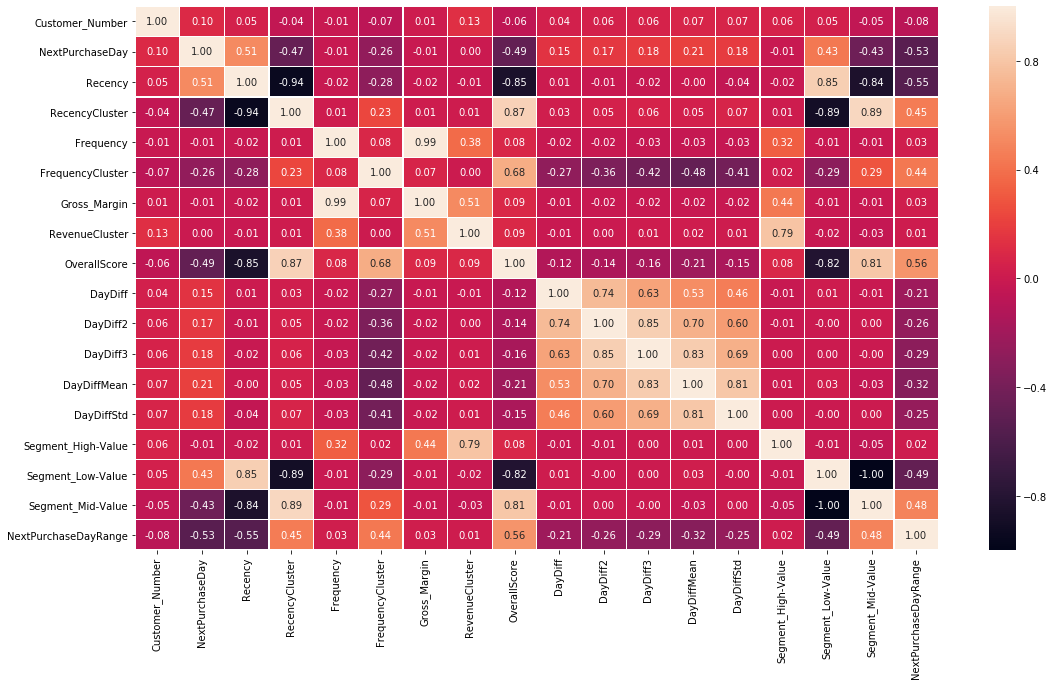

In [0]:
corr = tx_class[tx_class.columns].corr()
plt.figure(figsize = (18,10))-
sns.heatmap(corr, annot = True, linewidths=0.2, fmt=".2f")

In [0]:
tx_class = tx_class.drop('NextPurchaseDay',axis=1)
X, y = tx_class.drop('NextPurchaseDayRange',axis=1), tx_class.NextPurchaseDayRange

In [0]:
#train & test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=44)
#create an array of models
models = []
models.append(("LR",LogisticRegression()))
models.append(("NB",GaussianNB()))
models.append(("RF",RandomForestClassifier()))
models.append(("SVC",SVC()))
models.append(("Dtree",DecisionTreeClassifier()))
models.append(("XGB",xgb.XGBClassifier()))
models.append(("KNN",KNeighborsClassifier()))

#measure the accuracy 
for name,model in models:
    kfold = KFold(n_splits=2, random_state=22)
    cv_result = cross_val_score(model,X_train,y_train, cv = kfold,scoring = "accuracy")
    print(name, cv_result)

LR [0.66557556 0.67412257]
NB [0.68867067 0.62374977]
RF [0.66866703 0.67648663]
SVC [0.50009093 0.50663757]
Dtree [0.63720676 0.64520822]
XGB [0.70194581 0.70721949]
KNN [0.55300964 0.55228223]


In [0]:
xgb_model = xgb.XGBClassifier().fit(X_train, y_train)
print('Accuracy of XGB classifier on training set: {:.2f}'
       .format(xgb_model.score(X_train, y_train)))
print('Accuracy of XGB classifier on test set: {:.2f}'
       .format(xgb_model.score(X_test[X_train.columns], y_test)))

Accuracy of XGB classifier on training set: 0.73
Accuracy of XGB classifier on test set: 0.72


In [0]:
from sklearn.model_selection import GridSearchCV
param_test1 = {
 'max_depth':range(3,10,2),
 'min_child_weight':range(1,6,2)
}
gsearch1 = GridSearchCV(estimator = xgb.XGBClassifier(), 
param_grid = param_test1, scoring='accuracy',n_jobs=-1,iid=False, cv=2)
gsearch1.fit(X_train,y_train)
gsearch1.best_params_, gsearch1.best_score_

({'max_depth': 3, 'min_child_weight': 5}, 0.7048554282596835)

In [0]:
xgb_model = xgb.XGBClassifier(max_depth=3,min_child_weight=5).fit(X_train, y_train)
print('Accuracy of XGB classifier on training set: {:.2f}'
       .format(xgb_model.score(X_train, y_train)))
print('Accuracy of XGB classifier on test set: {:.2f}'
       .format(xgb_model.score(X_test[X_train.columns], y_test)))

Accuracy of XGB classifier on training set: 0.73
Accuracy of XGB classifier on test set: 0.72


In [0]:
##Time series based on LSTM  
#represent month in date field as its first day\
sales_dataFrame=store_df.copy()
sales_dataFrame['Date'] = sales_dataFrame['Date'].dt.year.astype('str') + '-' + sales_dataFrame['Date'].dt.month.astype('str') + '-01'
sales_dataFrame['Date'] = pd.to_datetime(sales_dataFrame['Date'])

In [0]:
sales_dataFrame = sales_dataFrame.groupby('Date').Net_Sales_Units.sum().reset_index()

In [0]:
sales_dataFrame.head()

,Date,Net_Sales_Units
0,2015-01-01,62954.21
1,2015-02-01,56366.43
2,2015-03-01,57342.96
3,2015-04-01,94091.02
4,2015-05-01,112033.61


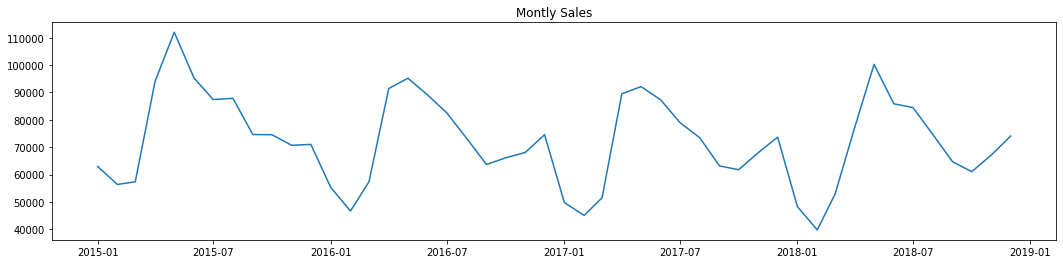

In [0]:
#plot monthly sales
plt.figure(figsize=(18,4))
plt.plot(sales_dataFrame['Date'],sales_dataFrame['Net_Sales_Units'])
plt.title("Montly Sales")
plt.savefig('/content/drive/My Drive/DataScience/FinalProject/'+storeName+'/LSTM_MonthlySales.png', bbox_inches = "tight")

In [0]:
#create a new dataframe to model the difference
sales_differenceDf = sales_dataFrame.copy()

In [0]:
#add previous sales to the next row
sales_differenceDf['prev_sales'] = sales_differenceDf['Net_Sales_Units'].shift(1)

In [0]:
sales_differenceDf.head()

,Date,Net_Sales_Units,prev_sales
0,2015-01-01,62954.21,NaN
1,2015-02-01,56366.43,62954.21
2,2015-03-01,57342.96,56366.43
3,2015-04-01,94091.02,57342.96
4,2015-05-01,112033.61,94091.02


In [0]:
#drop the null values and calculate the difference
sales_differenceDf = sales_differenceDf.dropna()

In [0]:
sales_differenceDf['diff'] = (sales_differenceDf['Net_Sales_Units'] - sales_differenceDf['prev_sales'])

In [0]:
sales_differenceDf.head(10)

,Date,Net_Sales_Units,prev_sales,diff
1,2015-02-01,56366.43,62954.21,-6587.78
2,2015-03-01,57342.96,56366.43,976.53
3,2015-04-01,94091.02,57342.96,36748.06
4,2015-05-01,112033.61,94091.02,17942.59
5,2015-06-01,95303.49,112033.61,-16730.12
6,2015-07-01,87404.47,95303.49,-7899.02
7,2015-08-01,87853.57,87404.47,449.10
8,2015-09-01,74626.64,87853.57,-13226.93
9,2015-10-01,74556.85,74626.64,-69.79
10,2015-11-01,70683.45,74556.85,-3873.40


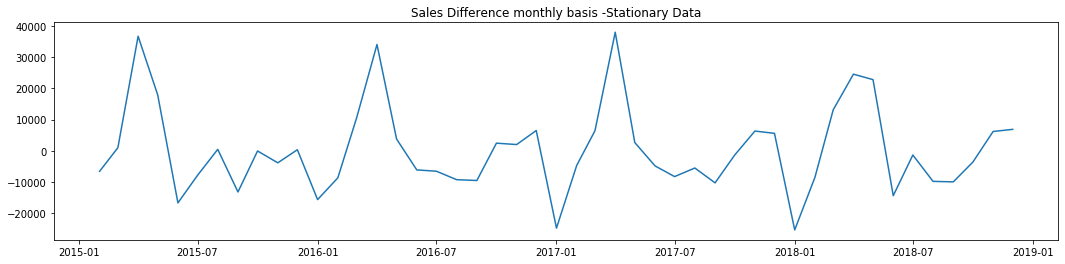

In [0]:
#plot sales diff
plt.figure(figsize=(18,4))
plt.plot(sales_differenceDf['Date'],sales_differenceDf['diff'])
plt.title("Sales Difference monthly basis -Stationary Data")
plt.savefig('/content/drive/My Drive/DataScience/FinalProject/'+storeName+'/LSTM_MonthlySales_stationary.png', bbox_inches = "tight")

In [0]:
#create new dataframe from transformation from time series to supervised
supervised_dataframe = sales_differenceDf.drop(['prev_sales'],axis=1)

In [0]:
#adding lags
for inc in range(1,13):
    field_name = 'lag_' + str(inc)
    supervised_dataframe[field_name] = supervised_dataframe['diff'].shift(inc)

In [0]:
#Drop months for getting non nan values looking at the past
supervised_dataframe=supervised_dataframe[12:]

In [0]:
supervised_dataframe

,Date,Net_Sales_Units,diff,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12
13,2016-02-01,46637.69,-8696.94,-15675.46,326.64,-3873.40,-69.79,-13226.93,449.10,-7899.02,-16730.12,17942.59,36748.06,976.53,-6587.78
14,2016-03-01,57346.66,10708.97,-8696.94,-15675.46,326.64,-3873.40,-69.79,-13226.93,449.10,-7899.02,-16730.12,17942.59,36748.06,976.53
15,2016-04-01,91452.46,34105.80,10708.97,-8696.94,-15675.46,326.64,-3873.40,-69.79,-13226.93,449.10,-7899.02,-16730.12,17942.59,36748.06
16,2016-05-01,95213.76,3761.30,34105.80,10708.97,-8696.94,-15675.46,326.64,-3873.40,-69.79,-13226.93,449.10,-7899.02,-16730.12,17942.59
17,2016-06-01,89059.42,-6154.34,3761.30,34105.80,10708.97,-8696.94,-15675.46,326.64,-3873.40,-69.79,-13226.93,449.10,-7899.02,-16730.12
18,2016-07-01,82495.90,-6563.52,-6154.34,3761.30,34105.80,10708.97,-8696.94,-15675.46,326.64,-3873.40,-69.79,-13226.93,449.10,-7899.02
19,2016-08-01,73213.15,-9282.75,-6563.52,-6154.34,3761.30,34105.80,10708.97,-8696.94,-15675.46,326.64,-3873.40,-69.79,-13226.93,449.10
20,2016-09-01,63663.56,-9549.59,-9282.75,-6563.52,-6154.34,3761.30,34105.80,10708.97,-8696.94,-15675.46,326.64,-3873.40,-69.79,-13226.93
21,2016-10-01,66097.92,2434.36,-9549.59,-9282.75,-6563.52,-6154.34,3761.30,34105.80,10708.97,-8696.94,-15675.46,326.64,-3873.40,-69.79
22,2016-11-01,68089.84,1991.92,2434.36,-9549.59,-9282.75,-6563.52,-6154.34,3761.30,34105.80,10708.97,-8696.94,-15675.46,326.64,-3873.40


In [0]:
import statsmodels.formula.api as smf 
# Regression formula
ols_model = smf.ols(formula='diff ~ lag_1', data=supervised_dataframe)
# Fit 
ols_model_fit = ols_model.fit()
#adjusted r-squared
regression_adj_rsq = ols_model_fit.rsquared_adj
print(regression_adj_rsq)

0.0473086209707233


In [0]:
import statsmodels.formula.api as smf 
# Define the regression formula
ols_model = smf.ols(formula='diff ~ lag_1 + lag_2 + lag_3 + lag_4 + lag_5 + lag_6 + lag_7 + lag_8 + lag_9 + lag_10+lag_11+lag_12 ', data=supervised_dataframe)

# Fit 
ols_model_fit = ols_model.fit()
# Adjusted r-squared
regression_adj_rsq = ols_model_fit.rsquared_adj
print(regression_adj_rsq)

0.8673691524133589


In [0]:
from sklearn.preprocessing import MinMaxScaler
df_model = supervised_dataframe.drop(['Net_Sales_Units','Date'],axis=1)

In [0]:
#split train and test set
train_set, test_set = df_model[0:-6].values, df_model[-6:].values

In [0]:
#apply Min Max Scaler
scaler = MinMaxScaler(feature_range=(-1, 1))
scaler = scaler.fit(train_set)
# reshape training set
train_set = train_set.reshape(train_set.shape[0], train_set.shape[1])
train_set_scaled = scaler.transform(train_set)

# reshape test set
test_set = test_set.reshape(test_set.shape[0], test_set.shape[1])
test_set_scaled = scaler.transform(test_set)

In [0]:
X_train, y_train = train_set_scaled[:, 1:], train_set_scaled[:, 0:1]
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])

In [0]:
X_test, y_test = test_set_scaled[:, 1:], test_set_scaled[:, 0:1]
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

In [0]:
model = Sequential()
model.add(LSTM(4, batch_input_shape=(1, X_train.shape[1], X_train.shape[2]), stateful=True))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X_train, y_train, nb_epoch=100, batch_size=1, verbose=1, shuffle=False)





Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Epoch 1/100





29/29 [==============================] - 5s 183ms/step - loss: 0.3507
Epoch 2/100
29/29 [==============================] - 0s 6ms/step - loss: 0.3206
Epoch 3/100
29/29 [==============================] - 0s 7ms/step - loss: 0.2971
Epoch 4/100
29/29 [==============================] - 0s 6ms/step - loss: 0.2791
Epoch 5/100
29/29 [==============================] - 0s 6ms/step - loss: 0.2646
Epoch 6/100
29/29 [==============================] - 0s 6ms/step - loss: 0.2523
Epoch 7/100
29/29 [==============================] - 0s 6ms/step - loss: 0.2415
Epoch 8/100
29/29 [==============================] - 0s 7ms/step - loss: 0.2317
Epoch 9/100
29/29 [==============================] - 0s 7ms/step - loss: 0.2226
Epoch 10/100
29/29 [==============================] - 0s 6ms/step - loss: 0.2140
Epoch 11/100
29/29 [==============================] - 0s 7ms/step - loss: 0.2058
Epoch 12/1

In [0]:
y_pred = model.predict(X_test,batch_size=1)

In [0]:
#reshape y_pred
y_pred = y_pred.reshape(y_pred.shape[0], 1, y_pred.shape[1])

In [0]:
#rebuild test set for inverse transform
pred_test_set = []
for index in range(0,len(y_pred)):
    print(np.concatenate([y_pred[index],X_test[index]],axis=1))
    pred_test_set.append(np.concatenate([y_pred[index],X_test[index]],axis=1))

[[-0.28578779 -0.6535885   0.52057986  0.57580961  0.21497641 -0.46759846
  -1.01815073 -0.0319855  -0.00902431 -0.25433779 -0.53781908 -0.38610091
  -0.47376792]]
[[-0.32903406 -0.24236431 -0.6535885   0.52057986  0.57580961  0.21497641
  -0.48091745 -1.01815073 -0.0319855  -0.00902431 -0.25433779 -0.53781908
  -0.38610091]]
[[-0.28882402 -0.50890776 -0.24236431 -0.6535885   0.52057986  0.57580961
   0.20785204 -0.48091745 -1.01815073 -0.0319855  -0.00902431 -0.25433779
  -0.53781908]]
[[-0.09242794 -0.51387703 -0.50890776 -0.24236431 -0.6535885   0.52057986
   0.57195993  0.20785204 -0.48091745 -1.01815073 -0.0319855  -0.00902431
  -0.25433779]]
[[ 0.41297439 -0.31368848 -0.51387703 -0.50890776 -0.24236431 -0.6535885
   0.51622894  0.57195993  0.20785204 -0.48091745 -1.01815073 -0.0319855
  -0.00902431]]
[[ 0.3537108  -0.00424656 -0.31368848 -0.51387703 -0.50890776 -0.24236431
  -0.66859542  0.51622894  0.57195993  0.20785204 -0.48091745 -1.01815073
  -0.0319855 ]]


In [0]:
#reshape pred_test_set
pred_test_set = np.array(pred_test_set)
pred_test_set = pred_test_set.reshape(pred_test_set.shape[0], pred_test_set.shape[2])

In [0]:
#inverse transform
pred_test_set_inverted = scaler.inverse_transform(pred_test_set)

In [0]:
#create dataframe that shows the predicted sales
result_list = []
sales_dates = list(sales_dataFrame[-7:].Date)
act_sales = list(sales_dataFrame[-7:].Net_Sales_Units)
for index in range(0,len(pred_test_set_inverted)):
    result_dict = {}
    result_dict['Date'] = sales_dates[index+1]
    result_dict['pred_value'] = int(pred_test_set_inverted[index][0] + act_sales[index])
    result_list.append(result_dict)
df_result = pd.DataFrame(result_list)

In [0]:
#merge with actual sales dataframe
df_sales_pred = pd.merge(sales_dataFrame,df_result,on='Date',how='left')

In [0]:
dfpred_netsale=sales_dataFrame[-6:]
# print(dfpred_netsale, 
print(df_result)
df_result.index
df_result

        Date  pred_value
0 2018-07-01       83107
1 2018-08-01       80361
2 2018-09-01       71808
3 2018-10-01       68051
4 2018-11-01       80447
5 2018-12-01       84746


,Date,pred_value
0,2018-07-01,83107
1,2018-08-01,80361
2,2018-09-01,71808
3,2018-10-01,68051
4,2018-11-01,80447
5,2018-12-01,84746


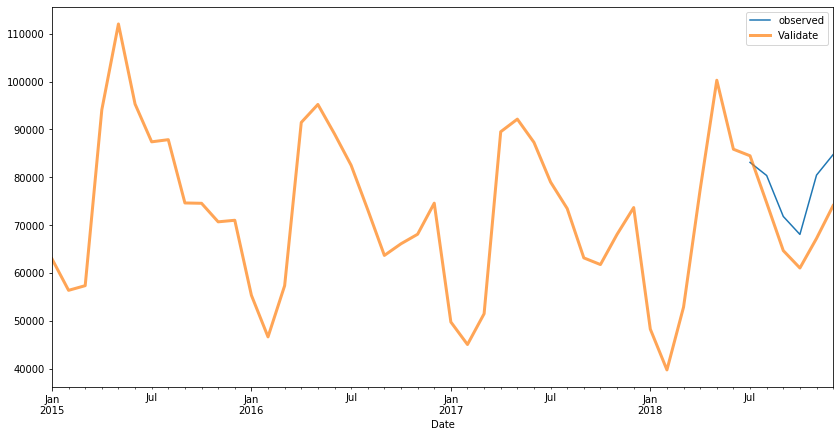

In [0]:
ax = df_result.plot(x='Date',y='pred_value',label='observed')
sales_dataFrame.plot(x='Date',y='Net_Sales_Units',ax=ax, label='Validate', alpha=.7, figsize=(14, 7),linewidth=3)
plt.legend()
plt.savefig('/content/drive/My Drive/DataScience/FinalProject/'+storeName+'/LSTM_Validation.png', bbox_inches = "tight")
plt.show()

In [0]:
#Drop columns with redundant info for time series analysis
lst=['Store_Name','Item_Description','Department_Name','Fineline_Name','Clerk','Line_#','Class_Name','Item_was_Scanned']
workspace_df.drop(columns=lst,inplace=True)

In [0]:
#df['df column_name'].apply(lambda x: 'value if condition is met' if x condition else 'value if condition is not met')
partial_df['Holiday Season']='No season'
partial_df.loc[(partial_df["Month"] ==1) & (partial_df["Day"] >= 7) &(partial_df['Day']<=14), "Holiday Season"]='Martin Luther King Jr'
partial_df.loc[(partial_df["Month"] ==2) & (partial_df["Day"] >= 19) &(partial_df['Day']<=24), "Holiday Season"]='Presidents Day '
partial_df.loc[(partial_df["Month"] ==3) & (partial_df["Day"] >= 14) &(partial_df['Day']<=21), "Holiday Season"]='St. Patricks Day'
partial_df.loc[(partial_df["Month"] ==1) & (partial_df["Day"] >= 1) &(partial_df['Day']<=7), "Holiday Season"]='NewYear'
partial_df.loc[(partial_df["Month"] ==12) & (partial_df["Day"] >= 20) &(partial_df['Day']<=31), "Holiday Season"]='Christmas'
partial_df.loc[(partial_df["Month"] ==11) & (partial_df["Day"] >= 1) &(partial_df['Day']<=30), "Holiday Season"]='ThanksGiving'

In [0]:
backup_df=partial_df.copy()

In [0]:
plt.figure(figsize=(18,6))
plt.plot(partial_df['Holiday Season'],partial_df['Net Sales Units'],color='r')
plt.bar(partial_df['Holiday Season'],partial_df['Net Sales Units'],color='c')
plt.xticks(rotation=90)
plt.tight_layout
plt.title('Net Sales Units vs Major Holiday Seasons')
plt.ylabel('Net Sale Units')
plt.xlabel('Holiday Seasons')
#plt.tight_layout()
plt.savefig('/content/drive/My Drive/DataScience/FinalProject/NetSaleUnitsVsMajorHolidaySeasons.png', bbox_inches = "tight")
plt.show()

In [0]:
#Cleaning data
partial_df=backup_df.copy()
partial_df['Net Sales']=partial_df['Net Sales'].astype(str)
partial_df['Net Sales']=partial_df['Net Sales'].str.replace(',', '')
partial_df=partial_df[partial_df['Store #'] != 'Store #']
partial_df["Net Sales"] = pd.to_numeric(partial_df["Net Sales"])

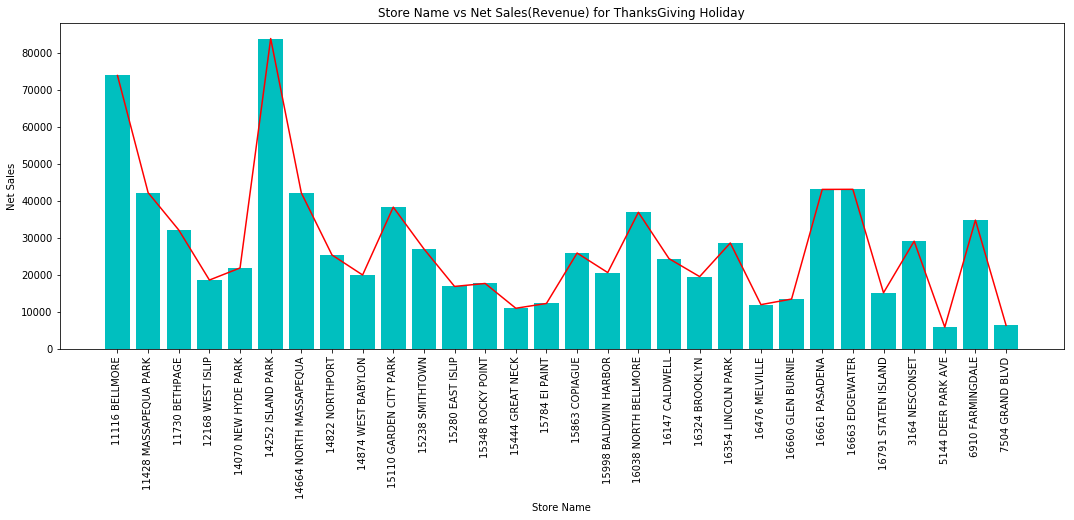

In [0]:
thanksGiving_df=partial_df[partial_df['Holiday Season']=='ThanksGiving']
store_thanksGiv_df=thanksGiving_df.groupby('Store Name').sum().reset_index()
store_thanksGiv_df=store_thanksGiv_df[store_thanksGiv_df['Store Name']!='13168 BOHEMIA WAREHOUSE']
plt.figure(figsize=(18,6))
plt.plot(store_thanksGiv_df['Store Name'],store_thanksGiv_df['Net Sales'],color='r')
plt.bar(store_thanksGiv_df['Store Name'],store_thanksGiv_df['Net Sales'],color='c')
plt.xticks(rotation=90)
plt.tight_layout
plt.title('Store Name vs Net Sales(Revenue) for ThanksGiving Holiday')
plt.ylabel('Net Sales')
plt.xlabel('Store Name')
plt.savefig('/content/drive/My Drive/DataScience/FinalProject/StoreNameVsNetSales.png', bbox_inches = "tight")
plt.show()

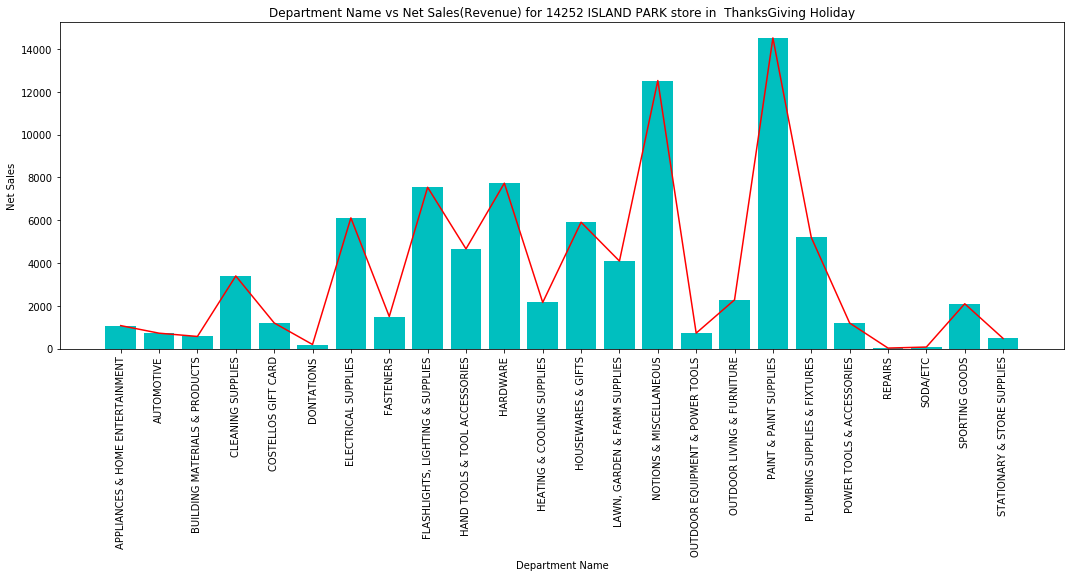

In [0]:
maxRevenueGeneratorStoreInThanksGiving_df=thanksGiving_df[thanksGiving_df['Store Name']=='14252 ISLAND PARK']
StoreNamevsDepartmentName_df=maxRevenueGeneratorStoreInThanksGiving_df.groupby('Department Name').sum().reset_index()    
removeNegativeFromDepartmentNetSales_df_df=StoreNamevsDepartmentName_df[StoreNamevsDepartmentName_df['Net Sales']>=0]
removeNegativeFromDepartmentNetSales_df_df
plt.figure(figsize=(18,6))
plt.plot(removeNegativeFromDepartmentNetSales_df_df['Department Name'],removeNegativeFromDepartmentNetSales_df_df['Net Sales'],color='r')
plt.bar(removeNegativeFromDepartmentNetSales_df_df['Department Name'],removeNegativeFromDepartmentNetSales_df_df['Net Sales'],color='c')
plt.xticks(rotation=90)
plt.tight_layout
plt.title('Department Name vs Net Sales(Revenue) for 14252 ISLAND PARK store in  ThanksGiving Holiday')
plt.ylabel('Net Sales')
plt.xlabel('Department Name')
plt.savefig('/content/drive/My Drive/DataScience/FinalProject/DepartmentNameVsNetSales.png', bbox_inches = "tight")
plt.show()

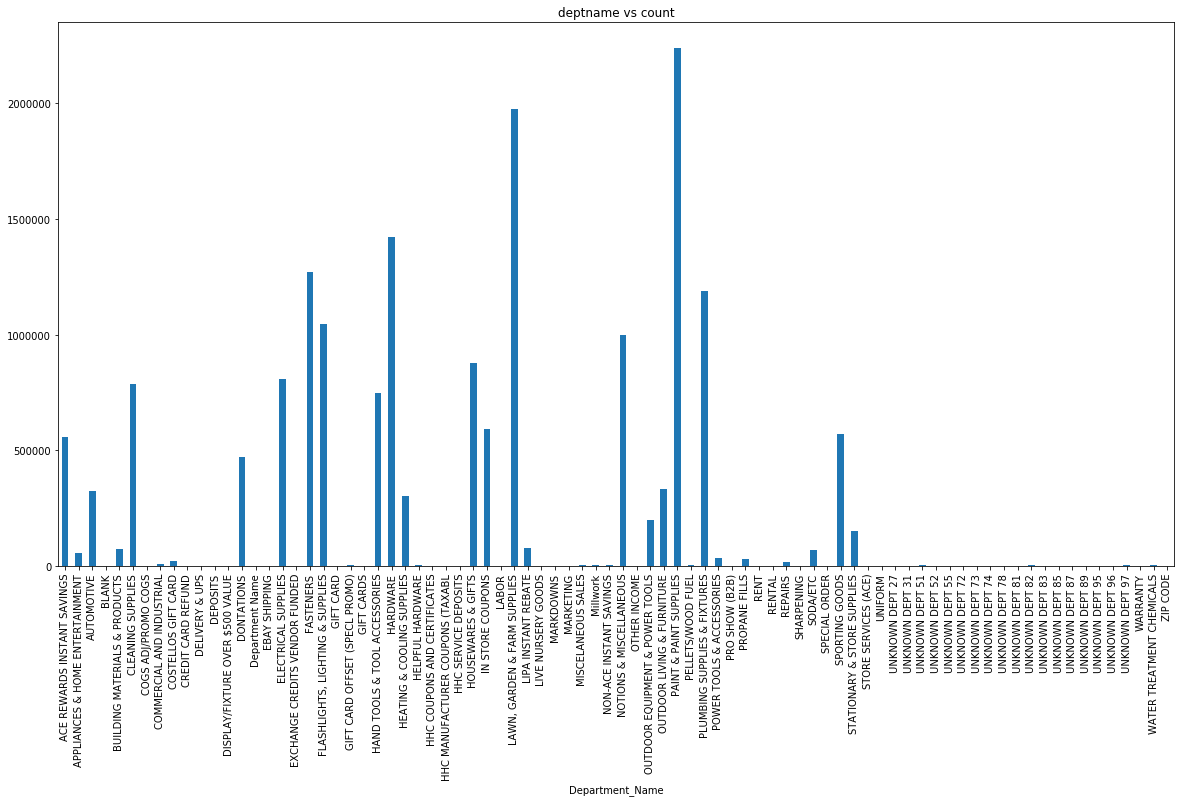

In [0]:
import matplotlib.pyplot as plt
full_df.groupby('Department_Name')['Department_Name'].count().plot(kind='bar',title='deptname vs count',figsize=(20,10))
plt.show()